# Advanced Data Science - Capstone Project

## Model Definition - V.2.01

### Carlos Granados

For this project I decided to use solar power generation data uploaded by [Ani Kannal](https://www.kaggle.com/anikannal "Ani Kannal Profile") in [kaggle.com website](https://www.kaggle.com/anikannal/solar-power-generation-data?select=Plant_1_Generation_Data.csv "Data Set from kaggle"). The idea is to predict the power generation given different weather conditions, as temperature and irradiation, and check the health of the devices.

#### NOTE:
The data sets are ready to be used. We perform here the steps pn ETL, data cleasing and feature engineering in a few cells...

### 0. Install keras:

Usually `keras` is not installed by default, so we need to install it first...

In [1]:
!pip install tensorflow==2.2.0rc0

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install keras==2.4.3

Defaulting to user installation because normal site-packages is not writeable


### 1. Load Libraries:

In [4]:
# Standard python libraries
import numpy as np
import types
import datetime as dt
from scipy import stats
from numpy.random import seed

# pandas
import pandas as pd

# Libraries to make plots and related
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.dates import DateFormatter

%matplotlib inline

# For Anomaly Detection, using keras
from keras.layers import Input, Dropout, Dense, LSTM
from keras.models import Model, Sequential
from keras.callbacks import Callback
#from tensorflow import set_random_seed
import tensorflow as tf

# Machine Learning using SciKitLearn
import sklearn
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Load custom functions, used in this notebook
from ADS_Capstone_model_definition_Aux import*

# Others, required by IBM Watson
#import ibm_boto3
#from botocore.client import Config

### 2. Re-Read and Check Data Frames

Before to start, lets repeat a couple of steps performed in the *Data Exploration* step.

Some cells are hidden, because they contain sensitive information, as some keys and passwords. The original data files, in CSV format, are already uploaded to IBM Watson project, and they are called from the notebook directly.

In [4]:
# @hidden_cell
#Created by IBM Watson, to load the data files already present in the project assets

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
#client_1332bfda1943460d8a3027fa1d74a9ab = ibm_boto3.client(service_name='s3',
#    ibm_api_key_id='PEEJQvt8RIdfeA43BnAcNewwGbaGVn6ePGzhsbzcVLoG',
#    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
#    config=Config(signature_version='oauth'),
#    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

In [5]:
# @hidden_cell

# Plant 1, generation and sensor data

#body0 = client_1332bfda1943460d8a3027fa1d74a9ab.get_object(
#    Bucket='appliedaideeplearning-donotdelete-pr-8geft8l4hehwko',
#    Key='Plant_1_Generation_Data.csv')['Body']

# add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body0, "__iter__"): body0.__iter__ = types.MethodType( __iter__, body0 )
    
#body1 = client_1332bfda1943460d8a3027fa1d74a9ab.get_object(
#    Bucket='appliedaideeplearning-donotdelete-pr-8geft8l4hehwko',
#    Key='Plant_1_Weather_Sensor_Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body1, "__iter__"): body1.__iter__ = types.MethodType( __iter__, body1 )

In [6]:
# Read generation data for Plant 1
#df_plant1_gen = pd.read_csv(body0)

# Read sensor data for Plant 1
#df_plant1_sen = pd.read_csv(body1)

In [7]:
# @hidden_cell

# Plant 2, generation and sensor data

#body0 = client_1332bfda1943460d8a3027fa1d74a9ab.get_object(
#    Bucket='appliedaideeplearning-donotdelete-pr-8geft8l4hehwko',
#    Key='Plant_2_Generation_Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body0, "__iter__"): body0.__iter__ = types.MethodType( __iter__, body0 )

#body1 = client_1332bfda1943460d8a3027fa1d74a9ab.get_object(
#    Bucket='appliedaideeplearning-donotdelete-pr-8geft8l4hehwko',
#    Key='Plant_2_Weather_Sensor_Data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
#if not hasattr(body1, "__iter__"): body1.__iter__ = types.MethodType( __iter__, body1 )

In [8]:
# Read generation data for Plant 2
#df_plant2_gen = pd.read_csv(body0)

# Read sensor data for Plant 2
#df_plant2_sen = pd.read_csv(body1)

In [4]:
# Path to CSV data files
path_data = '/resources/Projects/AnomalyDect/SolarPanels/Data/'

# Read generation data for Plant 1
df_plant1_gen = pd.read_csv(path_data+'Plant_1_Generation_Data.csv')

# Read sensor data for Plant 1
df_plant1_sen = pd.read_csv(path_data+'Plant_1_Weather_Sensor_Data.csv')

In [5]:
# Read generation data for Plant 2
df_plant2_gen = pd.read_csv(path_data+'Plant_2_Generation_Data.csv')

# Read sensor data for Plant 2
df_plant2_sen = pd.read_csv(path_data+'Plant_2_Weather_Sensor_Data.csv')

#### 2.1 ETL

##### Note: In order to evaluate the models, we will use only two different DFs, one for each plant...

As part pf the ETL step, the Date features must be transformed to the correct format

In [6]:
df_plant1_gen['DATE_TIME'] = pd.to_datetime(df_plant1_gen['DATE_TIME'])
df_plant1_sen['DATE_TIME'] = pd.to_datetime(df_plant1_sen['DATE_TIME'])
df_plant2_gen['DATE_TIME'] = pd.to_datetime(df_plant2_gen['DATE_TIME'])
df_plant2_sen['DATE_TIME'] = pd.to_datetime(df_plant2_sen['DATE_TIME'])

#### 2.2 Data Cleansing

Now, we see that the DF contains a column called "SOURCE_KEYS", which stands for the inverter ID, basically where the measurement were made. There are a set of them...

In [7]:
# Plant 1:
df_sub = df_plant1_gen['SOURCE_KEY'].value_counts().reset_index()
df_plant1a_gen = df_plant1_gen[df_plant1_gen['SOURCE_KEY'] == df_sub['index'][0]]

In [8]:
# Plant 2:
df_sub = df_plant2_gen['SOURCE_KEY'].value_counts().reset_index()
df_plant2a_gen = df_plant2_gen[df_plant2_gen['SOURCE_KEY'] == df_sub['index'][0]]

In [9]:
# Merging data for Plant 1:

df_plant1a = df_plant1a_gen.merge(df_plant1_sen, on='DATE_TIME', how='left')

In [10]:
# Merging data for Plant 2:

df_plant2a = df_plant2a_gen.merge(df_plant2_sen, on='DATE_TIME', how='left')

#### 2.3 Feature Engineering

Now we start looking at the features on the DFs. We add the month and the time of the day to the DFs

In [11]:
# We add MONTH, DAY and DT_TIME

# Plant 1:
df_plant1a['MONTH'] = pd.DatetimeIndex(df_plant1a['DATE_TIME']).month
df_plant1a['DAY'] = pd.DatetimeIndex(df_plant1a['DATE_TIME']).day
df_plant1a['DT_TIME'] = pd.to_datetime(df_plant1a['DATE_TIME'])

# Plant 2:
df_plant2a['MONTH'] = pd.DatetimeIndex(df_plant2a['DATE_TIME']).month
df_plant2a['DAY'] = pd.DatetimeIndex(df_plant2a['DATE_TIME']).day
df_plant2a['DT_TIME'] = pd.to_datetime(df_plant2a['DATE_TIME'])

In [12]:
# Adding time in float format for Plant 1 A-C:
dfa = df_plant1a['DT_TIME']
df_plant1a['TIME'] = dfa.dt.hour + dfa.dt.minute/60.0

# Adding time in float format for Plant 2 A-C:
dfa = df_plant2a['DT_TIME']
df_plant2a['TIME'] = dfa.dt.hour + dfa.dt.minute/60.0

We now proceed to fill the missing times...

In [13]:
t = np.arange(0, 24, 0.25)
times = []
headers = ['TIME', 'DAY', 'MONTH']

# Add days for May
for day in range(15, 32):
    for i in range(96):
        times.append([t[i], day, 5])

# Add days for June
for day in range(1, 18):
    for i in range(96):
        times.append([t[i], day, 6])
        
times = np.array(times)
df_times = pd.DataFrame(data=times, columns=headers)

In [14]:
# Plant 1:
df_plant1a = df_times.merge(df_plant1a, on=['TIME', 'DAY', 'MONTH'], how='left')
df_plant1a.fillna(0, inplace=True)

# Plant 2:
df_plant2a = df_times.merge(df_plant2a, on=['TIME', 'DAY', 'MONTH'], how='left')
df_plant2a.fillna(0, inplace=True)

As a final procedure, we drop the features that will not be used on the training, and rename some of them...

In [15]:
cols = ['DATE_TIME', 'DAY', 'PLANT_ID_x', 'SOURCE_KEY_x', 'SOURCE_KEY_y',
        'PLANT_ID_y', 'TOTAL_YIELD', 'DT_TIME']

# Plant 1:
df_plant1a.drop(cols, axis=1, inplace=True)

# Plant 2:
df_plant2a.drop(cols, axis=1, inplace=True)

In [16]:
# For "AMBIENT TEMPERATURE"

dic1 = {"AMBIENT_TEMPERATURE": "AMB_TEMP"}

# Plant 1:
df_plant1a.rename(columns=dic1, inplace=True)

# Plant 2:
df_plant2a.rename(columns=dic1, inplace=True)

In [17]:
# For "MODULE TEMPERATURE"

dic2 = {"MODULE_TEMPERATURE": "MOD_TEMP"}

# Plant 1:
df_plant1a.rename(columns=dic2, inplace=True)

# Plant 2:
df_plant2a.rename(columns=dic2, inplace=True)

As a last procedure, we rearrange the columns, to have a more logical order...

In [18]:
cols = ['TIME', 'MONTH', 'AMB_TEMP', 'MOD_TEMP', 'IRRADIATION', 'DAILY_YIELD', 'AC_POWER', 'DC_POWER']

# Plant 1:
df_plant1a = df_plant1a[cols]

# Plant 2:
df_plant2a = df_plant2a[cols]

Let's check the content of some of the DFs

In [24]:
df_plant1a.head(10)

TIME  MONTH   AMB_TEMP   MOD_TEMP  IRRADIATION  DAILY_YIELD  AC_POWER  \
0  0.00    5.0  25.184316  22.857507          0.0          0.0       0.0   
1  0.25    5.0  25.084589  22.761668          0.0          0.0       0.0   
2  0.50    5.0  24.935753  22.592306          0.0          0.0       0.0   
3  0.75    5.0  24.846130  22.360852          0.0          0.0       0.0   
4  1.00    5.0  24.621525  22.165423          0.0          0.0       0.0   
5  1.25    5.0  24.536092  21.968571          0.0          0.0       0.0   
6  1.50    5.0  24.638674  22.352926          0.0          0.0       0.0   
7  1.75    5.0  24.873022  23.160919          0.0          0.0       0.0   
8  2.00    5.0  24.936930  23.026113          0.0          0.0       0.0   
9  2.25    5.0  25.012248  23.343229          0.0          0.0       0.0   

   DC_POWER  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
5       0.0  
6       0.0  
7       0.0  
8       0.0  
9       0.0

In [25]:
df_plant1a.describe()

TIME        MONTH     AMB_TEMP     MOD_TEMP  IRRADIATION  \
count  3264.000000  3264.000000  3264.000000  3264.000000  3264.000000   
mean     11.875000     5.500000    24.708260    30.140594     0.222556   
std       6.928889     0.500077     5.652915    13.304568     0.299189   
min       0.000000     5.000000     0.000000     0.000000     0.000000   
25%       5.937500     5.000000    22.570805    20.935733     0.000000   
50%      11.875000     5.500000    24.439562    24.139106     0.010483   
75%      17.812500     6.000000    27.859856    40.800622     0.438055   
max      23.750000     6.000000    35.252486    65.545714     1.221652   

       DAILY_YIELD     AC_POWER      DC_POWER  
count  3264.000000  3264.000000   3264.000000  
mean   3041.770261   267.536014   2734.525002  
std    2881.455848   358.951623   3671.594435  
min       0.000000     0.000000      0.000000  
25%       0.000000     0.000000      0.000000  
50%    2547.928572     7.088393     73.544643  
75%    5751.080357   538.938839   5498.776786  
max    8131.000000  1265.157143  12976.000000

### 3. Model Definition

#### 3.1 Deep Learning Model

We want to perfomr an anomaly detection on the data, so we will use an autoencoder, particularly a LSTM neural network, using `keras`... We need to definy wich are the best activation functions, but particularly the loss and optimizer functions!

##### 3.1.1 We start defining a small neural network...

In [26]:
def anomalyModel(X, timesteps, dim, actFun):
    """
    Function to define a 'toy' neural network, to find
    the most accurate accurate activation functions and
    the loss and accuracy funtions as well
    X          : DF with the training data
    batch_size : (int)
    actFun     : (str)
    """
    shape = (timesteps, dim)
    inputs = Input(shape=shape)
    L1 = LSTM(100, activation=actFun, return_sequences=True)(inputs)
    L2 = LSTM(75, activation=actFun, return_sequences=True)(L1)
    L3 = LSTM(50, activation=actFun, return_sequences=True)(L2)
    L4 = LSTM(25, activation=actFun, return_sequences=True)(L3)
    outputs = Dense(units=dim)(L4)
    model = Model(inputs=inputs, outputs=outputs)
    return model

We need to trimm the DFs in small batches... We use the `create_trimmed_data` and the `create_trimmed_data_norm` functions, defined in the helper file.

We define also some functions that help to keep track of the losses and the optimizations

In [20]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))

We can start with the evaluation

In [24]:
# Defining the functions to be used

actFuns = ['tanh', 'softmax', 'sigmoid', 'relu']
optimizers = ['sgd', 'adam', 'adadelta', 'adagrad', 'adamax', 'nadam', 'ftrl']
losses = ['mae', 'mse', 'msle', 'Huber']

In [33]:
# Check dimensionality of Data Set...

df_plant1a.shape

(3264, 8)

We start evaluating the performance of each model. The function `lossExplorer` is defined in the corresponsing helper file...

Loss :  mae
Optimizer :  sgd
(4, 40)


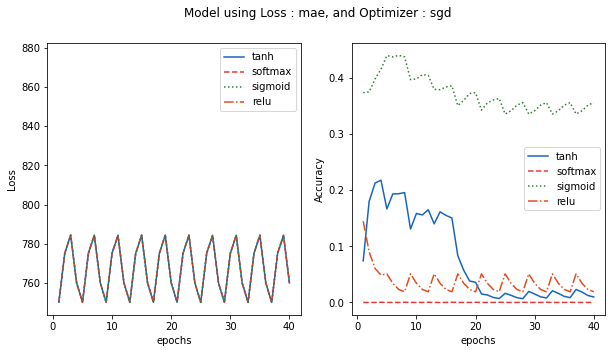

Optimizer :  adam
(4, 40)


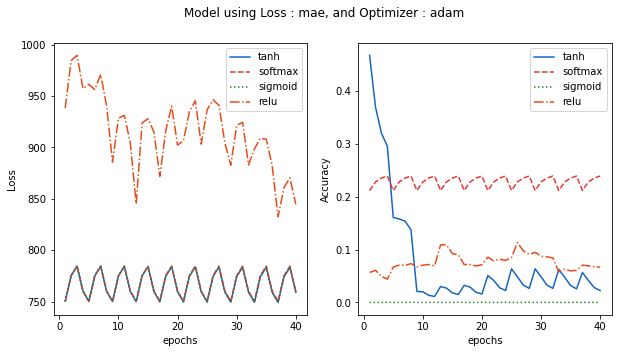

Optimizer :  adadelta
(4, 40)


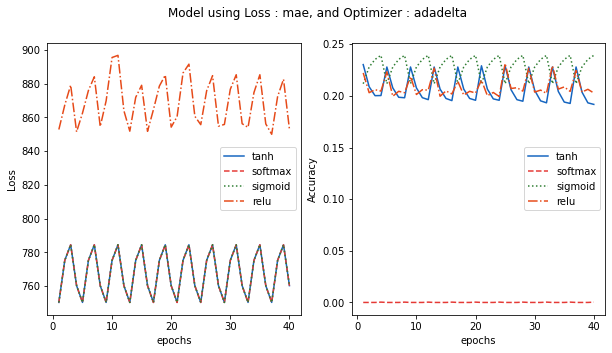

Optimizer :  adagrad
(4, 40)


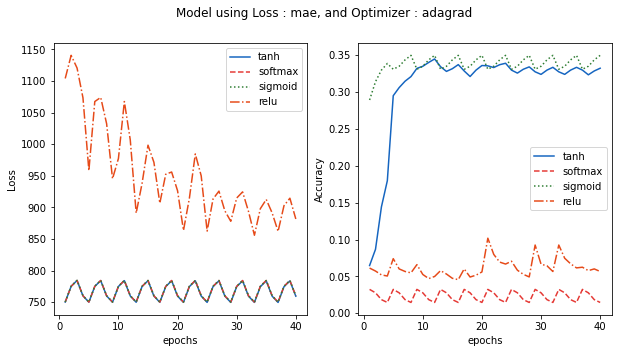

Optimizer :  adamax
(4, 40)


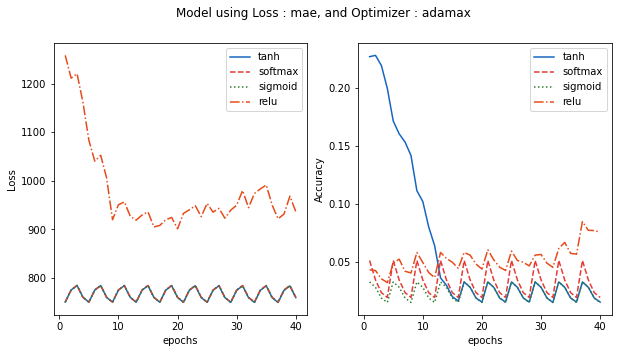

Optimizer :  nadam
(4, 40)


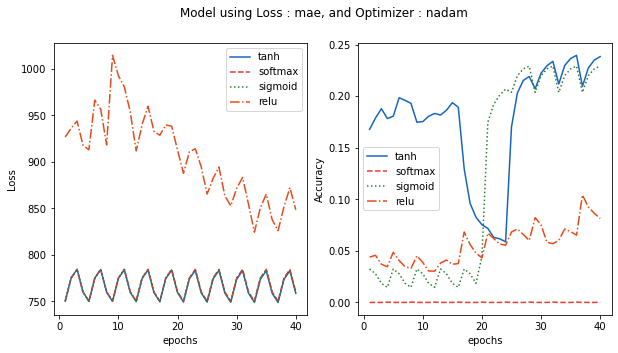

Optimizer :  ftrl
(4, 40)


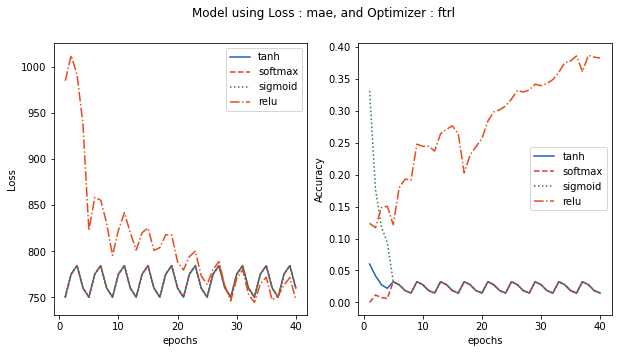

Loss :  mse
Optimizer :  sgd
(4, 40)


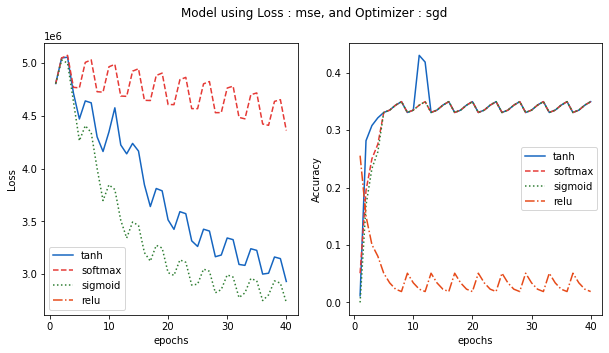

Optimizer :  adam
(4, 40)


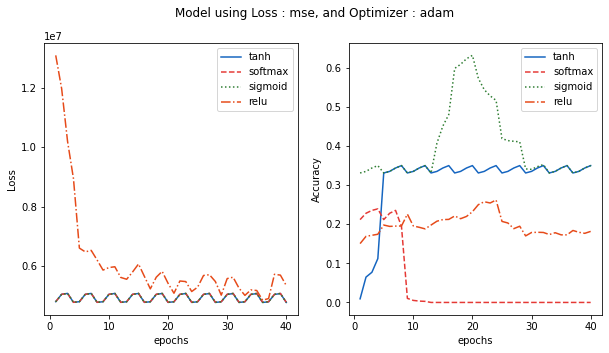

Optimizer :  adadelta
(4, 40)


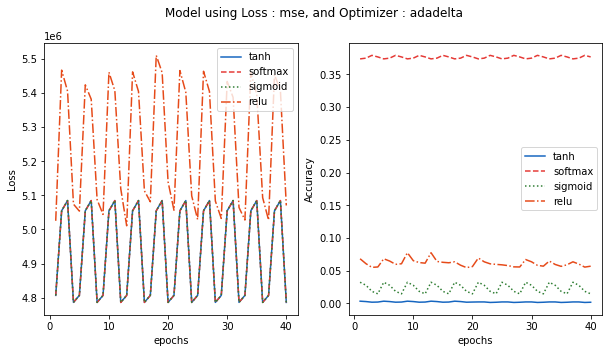

Optimizer :  adagrad
(4, 40)


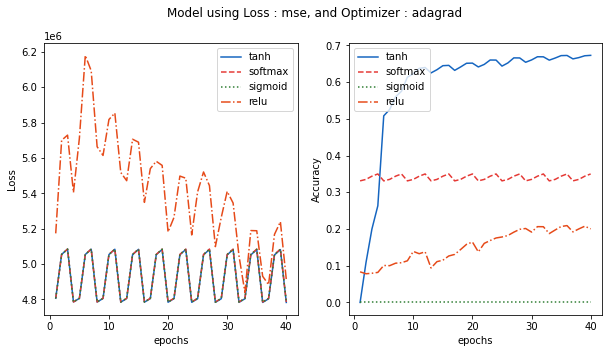

Optimizer :  adamax
(4, 40)


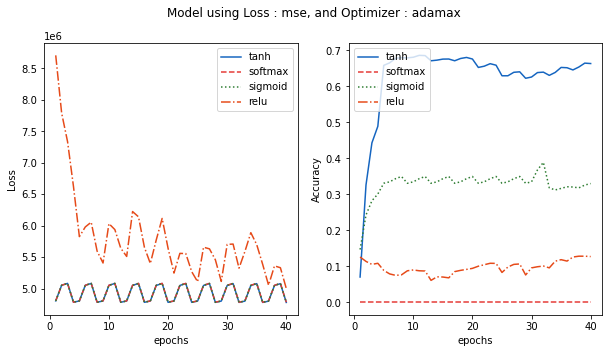

Optimizer :  nadam
(4, 40)


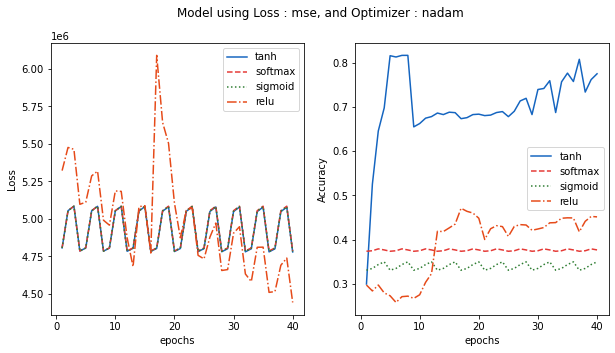

Optimizer :  ftrl
(4, 40)


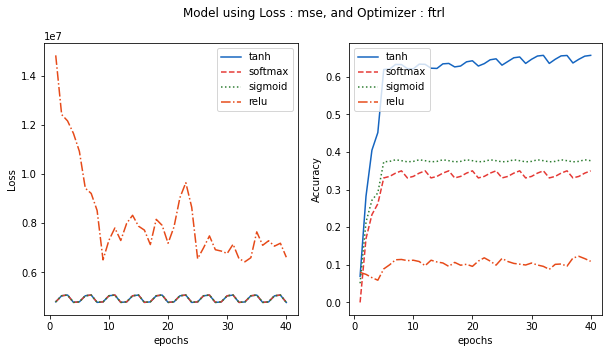

Loss :  msle
Optimizer :  sgd
(4, 40)


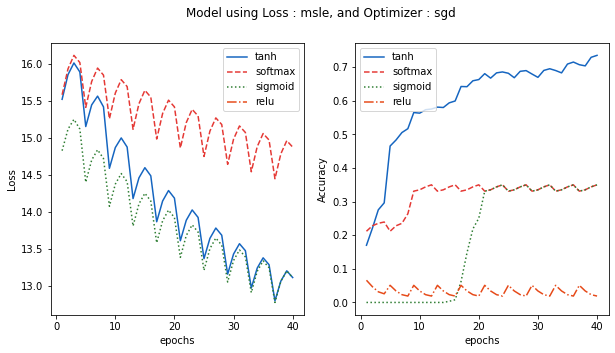

Optimizer :  adam
(4, 40)


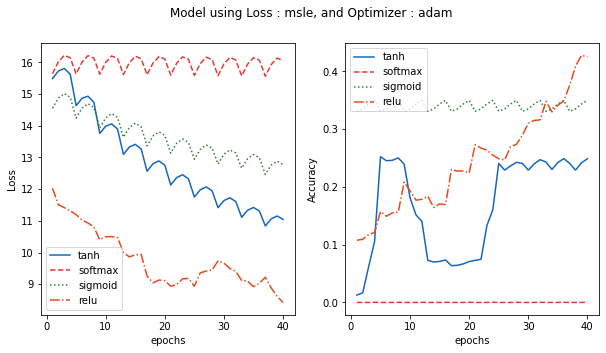

Optimizer :  adadelta
(4, 40)


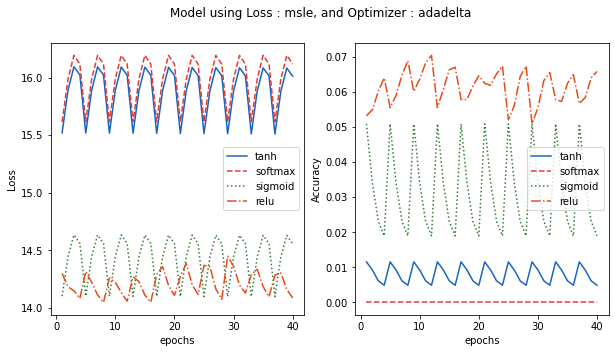

Optimizer :  adagrad
(4, 40)


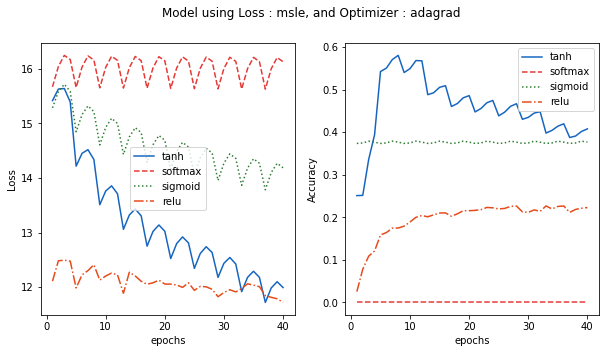

Optimizer :  adamax
(4, 40)


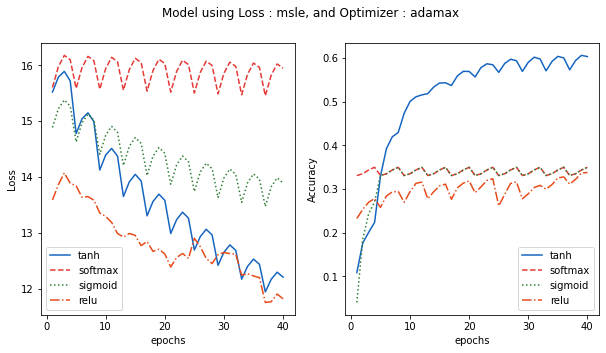

Optimizer :  nadam
(4, 40)


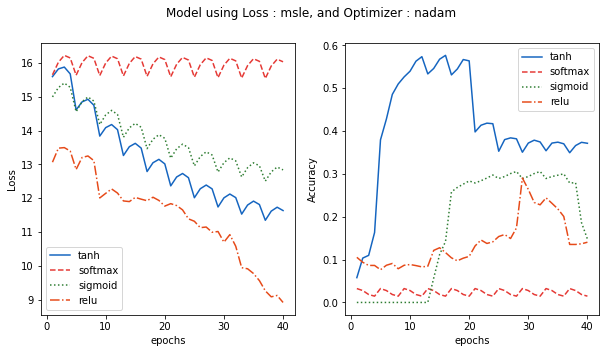

Optimizer :  ftrl
(4, 40)


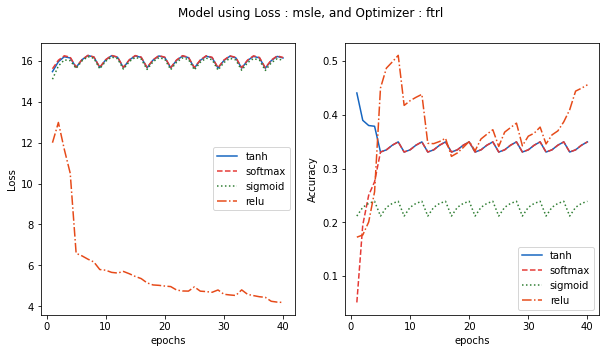

Loss :  Huber
Optimizer :  sgd
(4, 40)


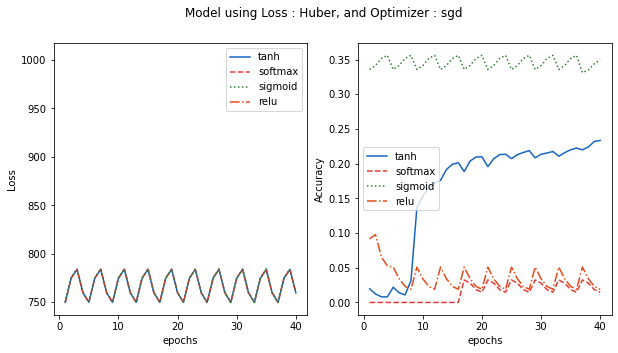

Optimizer :  adam
(4, 40)


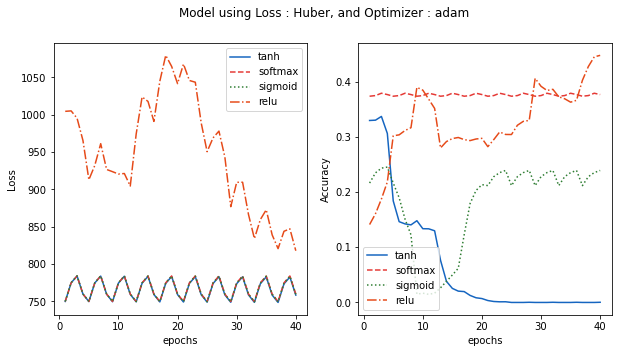

Optimizer :  adadelta
(4, 40)


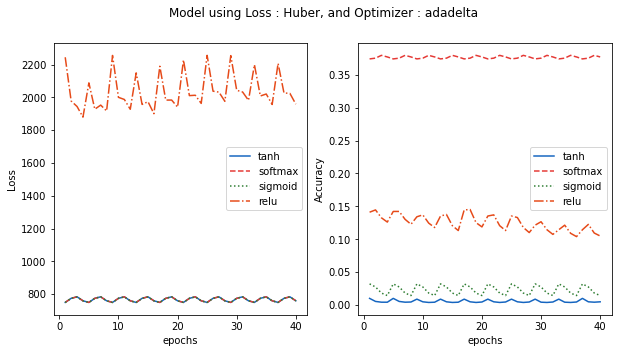

Optimizer :  adagrad
(4, 40)


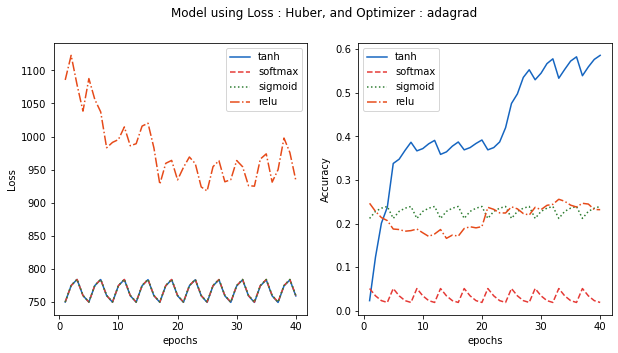

Optimizer :  adamax
(4, 40)


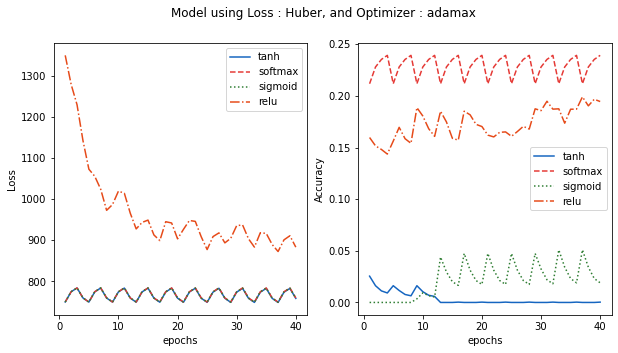

Optimizer :  nadam
(4, 40)


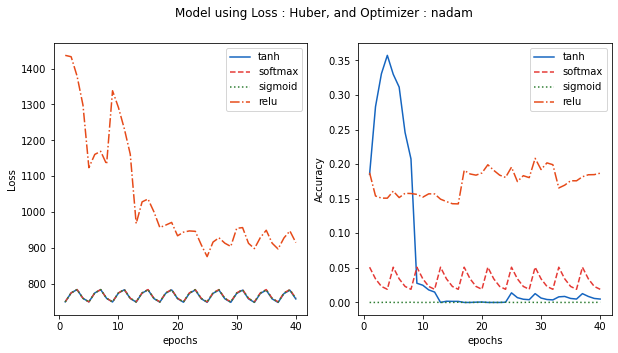

Optimizer :  ftrl
(4, 40)


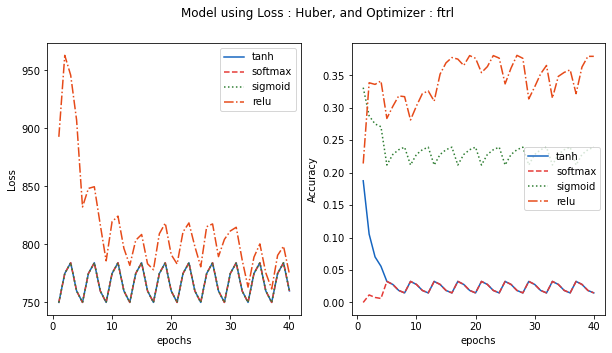

In [34]:
# Some additional parameters:
timesteps = 24 #96
dim = 8
batch_size = 36
epochs = 10

evalNoNorm = lossExplorer(losses, optimizers, actFuns,
                          df_data=df_plant1a,
                          dataTrimming=create_trimmed_data,
                          testModel=anomalyModel)

We will save the losses and the accuracy at the end of the training...

In [35]:
[df_evalNoNorm_Loss, df_evalNoNorm_Acc] = eval2df(evalNoNorm, actFuns)

['Loss-Opt.' 'tanh' 'softmax' 'sigmoid' 'relu']


In [36]:
df_evalNoNorm_Loss.head()

Loss-Opt.               tanh            softmax            sigmoid  \
0       mae - sgd   760.108642578125      760.228515625  760.1378784179688   
1      mae - adam  759.0072021484375  760.2274780273438  759.3662719726562   
2  mae - adadelta  760.2855834960938   760.262939453125  760.2761840820312   
3   mae - adagrad   759.615478515625  760.2535400390625  760.1793212890625   
4    mae - adamax  759.5148315429688   760.232666015625  759.5355834960938   

                relu  
0                nan  
1   844.577392578125  
2  853.0370483398438  
3  881.8181762695312  
4  936.4622192382812

In [37]:
df_evalNoNorm_Acc.head()

Loss-Opt.                  tanh                 softmax  \
0       mae - sgd  0.009803921915590763  0.00030637255986221135   
1      mae - adam   0.02236519567668438      0.2392769604921341   
2  mae - adadelta   0.19178920984268188  0.00030637255986221135   
3   mae - adagrad    0.3324142098426819    0.014705882407724857   
4    mae - adamax  0.015012254938483238    0.018995098769664764   

                  sigmoid                  relu  
0     0.35600489377975464  0.018995098769664764  
1  0.00030637255986221135   0.06678921729326248  
2      0.2392769604921341    0.2028186321258545  
3      0.3498774468898773   0.05667892098426819  
4    0.014705882407724857   0.07536764442920685

In [38]:
# Save data to a CSV file

path = '/resources/Projects/AnomalyDect/SolarPanels/model_def/'
df_evalNoNorm_Loss.to_csv('path'+'EvalNoNorm_Loss.csv')
df_evalNoNorm_Acc.to_csv('path'+'EvalNoNorm_Acc.csv')

##### 3.1.2 We can try a similar evaluation process, considering a normalized data set...

Loss :  mae
Optimizer :  sgd
(4, 40)


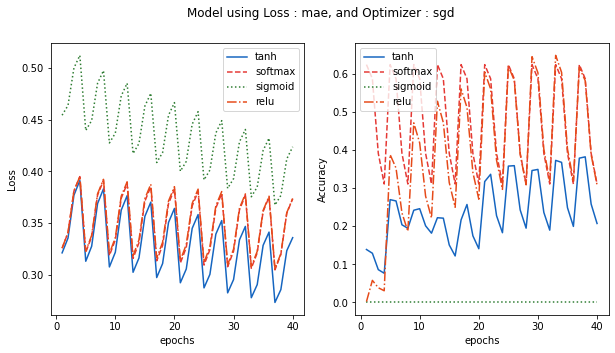

Optimizer :  adam
(4, 40)


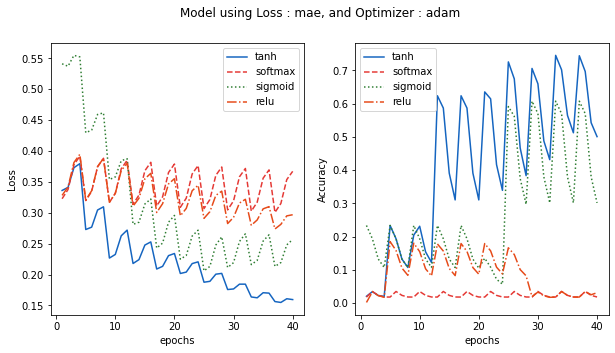

Optimizer :  adadelta
(4, 40)


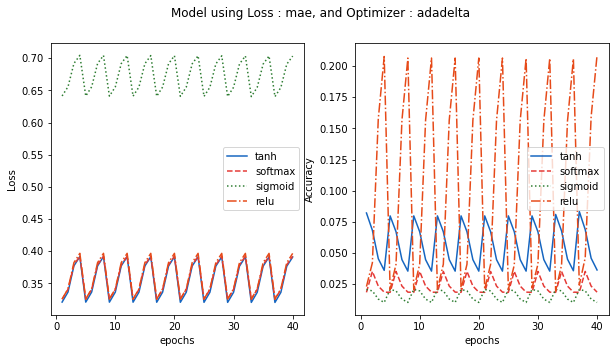

Optimizer :  adagrad
(4, 40)


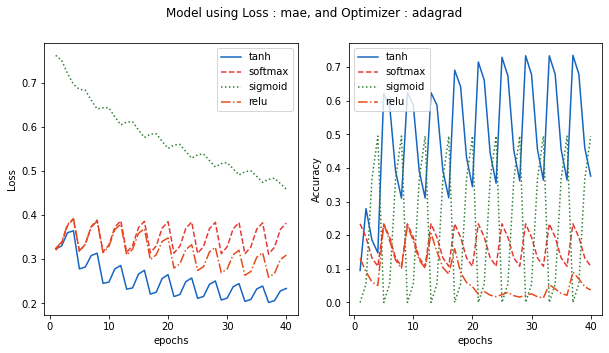

Optimizer :  adamax
(4, 40)


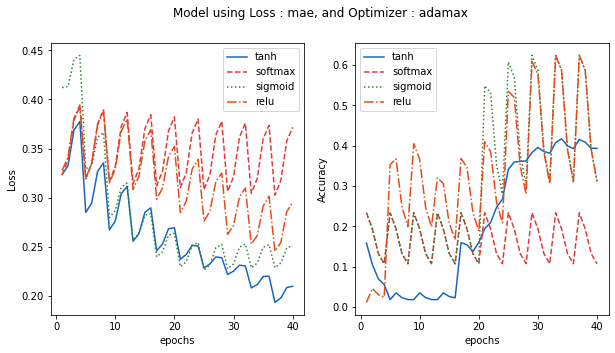

Optimizer :  nadam
(4, 40)


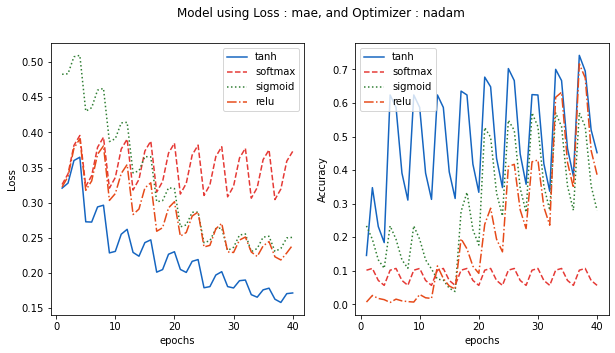

Optimizer :  ftrl
(4, 40)


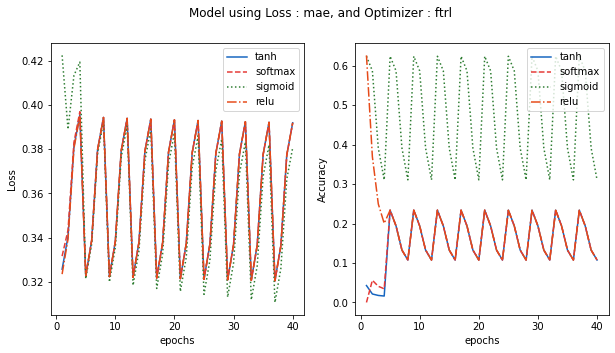

Loss :  mse
Optimizer :  sgd
(4, 40)


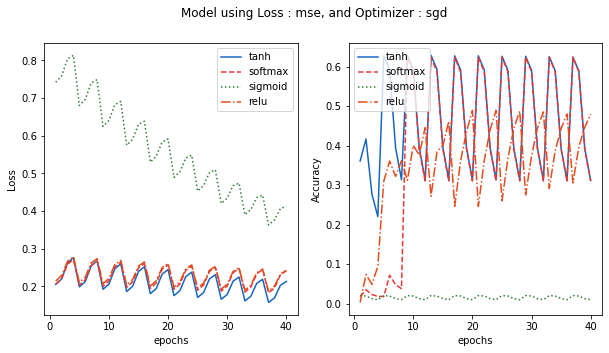

Optimizer :  adam
(4, 40)


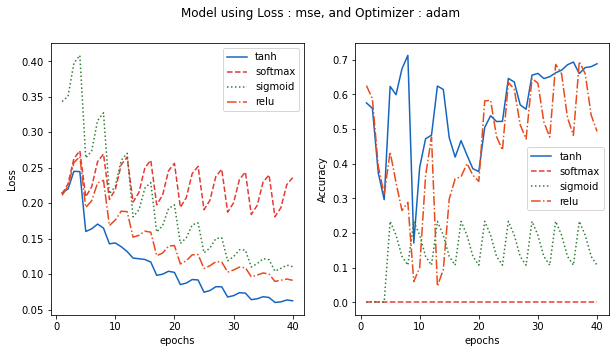

Optimizer :  adadelta
(4, 40)


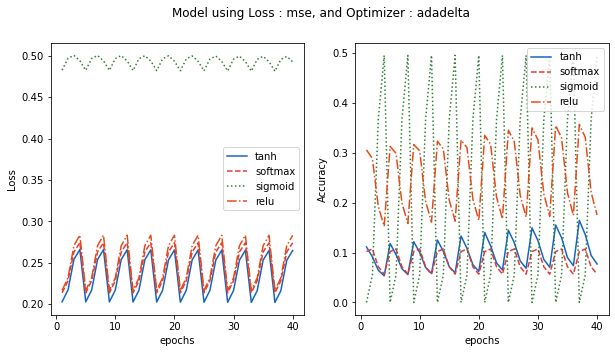

Optimizer :  adagrad
(4, 40)


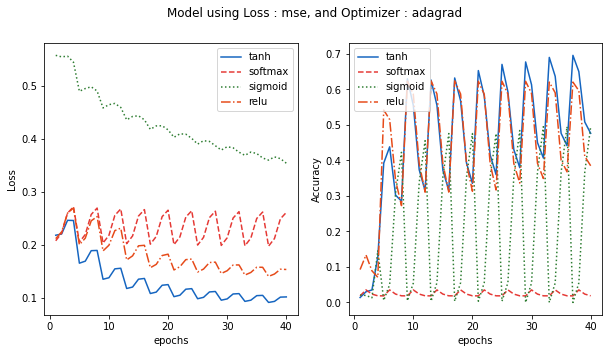

Optimizer :  adamax
(4, 40)


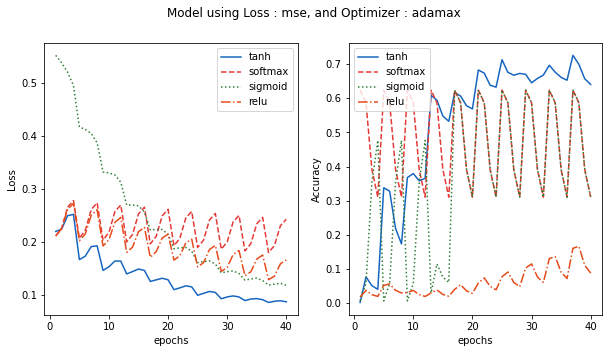

Optimizer :  nadam
(4, 40)


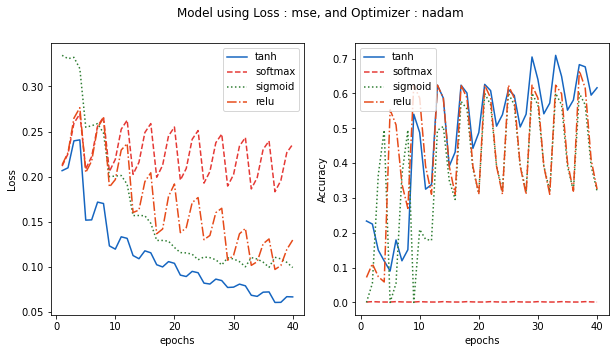

Optimizer :  ftrl
(4, 40)


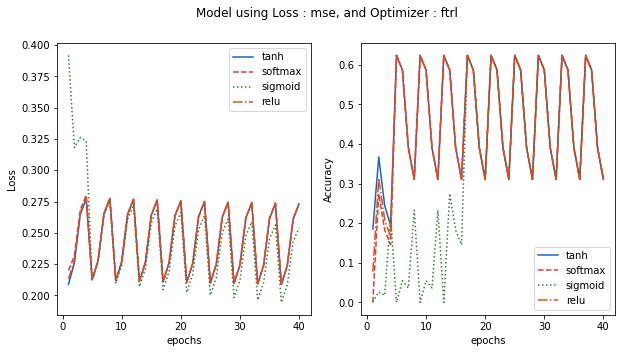

Loss :  msle
Optimizer :  sgd
(4, 40)


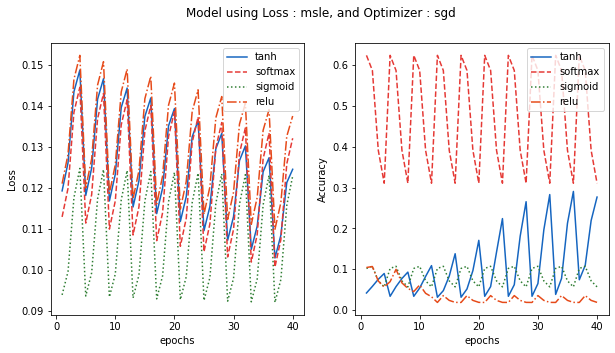

Optimizer :  adam
(4, 40)


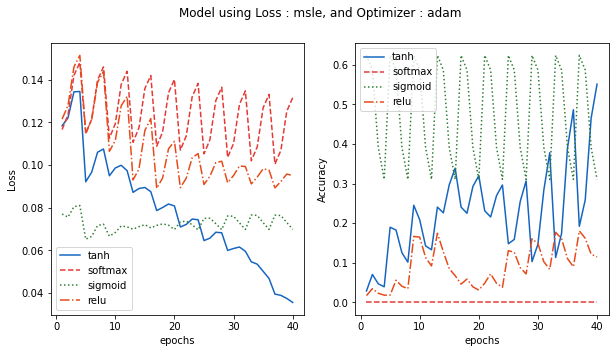

Optimizer :  adadelta
(4, 40)


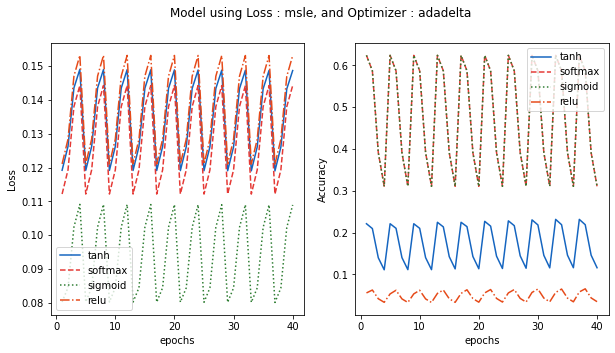

Optimizer :  adagrad
(4, 40)


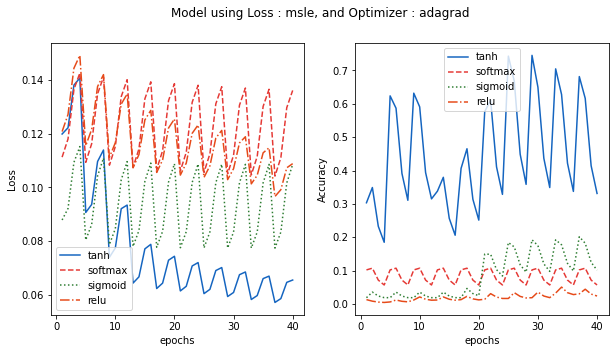

Optimizer :  adamax
(4, 40)


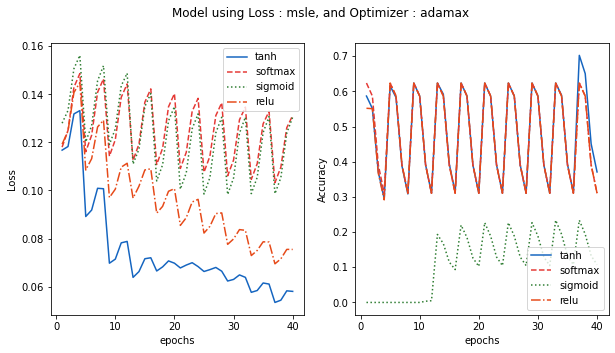

Optimizer :  nadam
(4, 40)


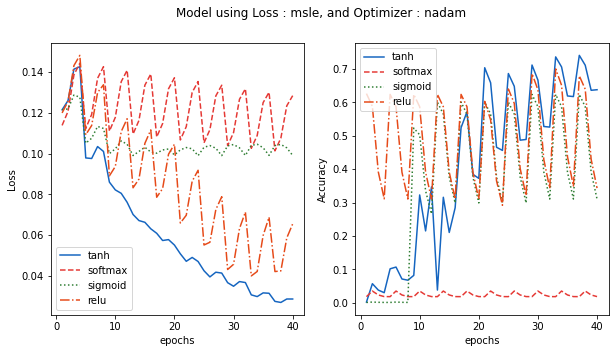

Optimizer :  ftrl
(4, 40)


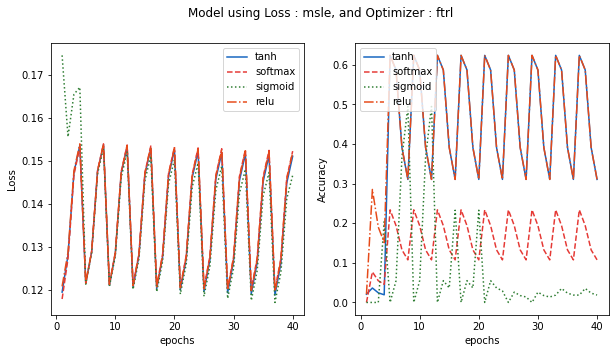

Loss :  Huber
Optimizer :  sgd
(4, 40)


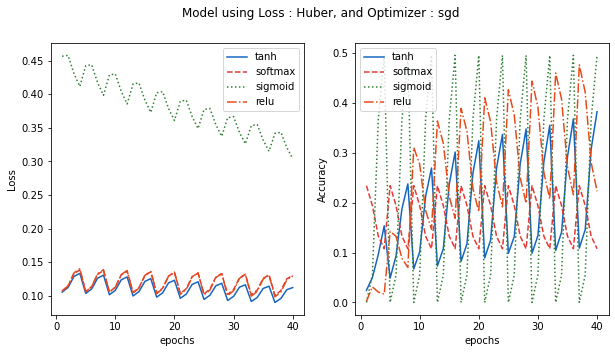

Optimizer :  adam
(4, 40)


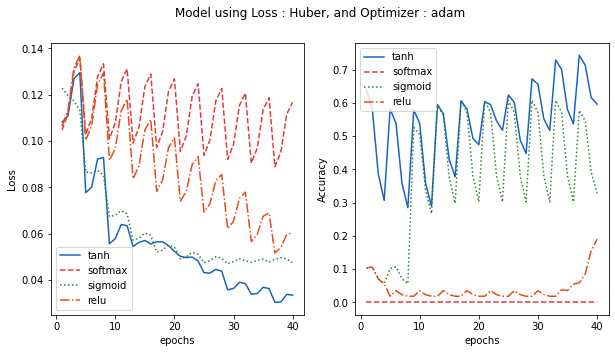

Optimizer :  adadelta
(4, 40)


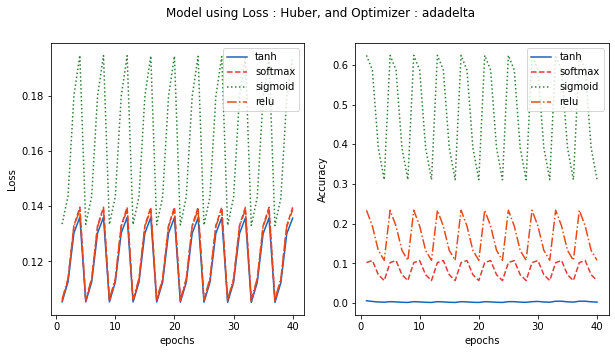

Optimizer :  adagrad
(4, 40)


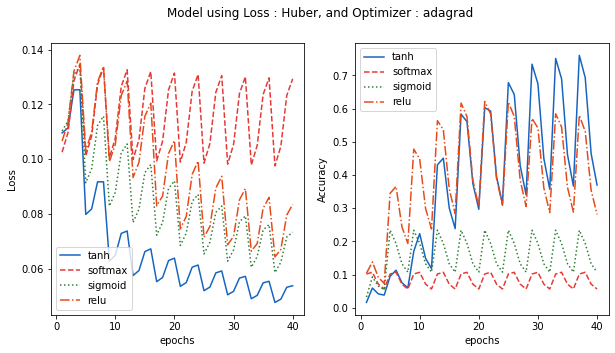

Optimizer :  adamax
(4, 40)


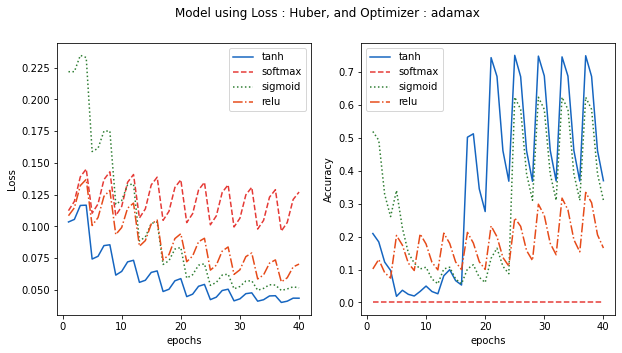

Optimizer :  nadam
(4, 40)


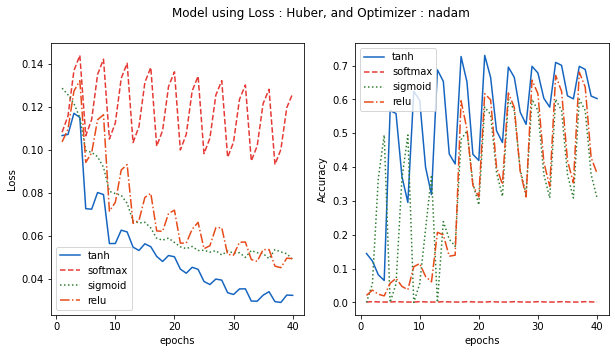

Optimizer :  ftrl
(4, 40)


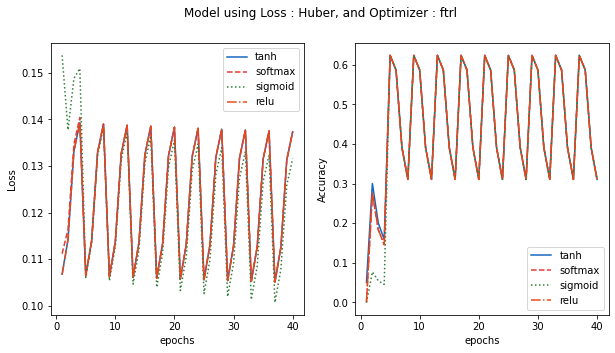

In [39]:
# Some additional parameters:
timesteps = 24 #96
dim = 8
batch_size = 36
epochs = 10

evalNorm = lossExplorer(losses, optimizers, actFuns,
                        df_data=df_plant1a,
                        dataTrimming=create_trimmed_data_norm,
                        testModel=anomalyModel)

In [40]:
[df_evalNorm_Loss, df_evalNorm_Acc] = eval2df(evalNorm, actFuns)

['Loss-Opt.' 'tanh' 'softmax' 'sigmoid' 'relu']


In [41]:
df_evalNorm_Loss.head()

Loss-Opt.                 tanh              softmax  \
0       mae - sgd  0.33574771881103516  0.37344813346862793   
1      mae - adam  0.15953703224658966    0.367127001285553   
2  mae - adadelta  0.39098212122917175   0.3920820951461792   
3   mae - adagrad   0.2339339554309845   0.3820658326148987   
4    mae - adamax  0.20989277958869934  0.37167295813560486   

               sigmoid                 relu  
0  0.42378535866737366  0.37369364500045776  
1  0.25682681798934937  0.29687726497650146  
2   0.7034148573875427  0.39659225940704346  
3   0.4590184688568115  0.30948546528816223  
4  0.25113654136657715  0.29545462131500244

In [42]:
df_evalNorm_Acc.head()

Loss-Opt.                 tanh              softmax  \
0       mae - sgd  0.20710784196853638  0.31066176295280457   
1      mae - adam   0.5009191036224365  0.01868872530758381   
2  mae - adadelta   0.0364583320915699  0.01868872530758381   
3   mae - adagrad   0.3759191036224365  0.10753676295280457   
4    mae - adamax  0.39338234066963196  0.10753676295280457   

                sigmoid                  relu  
0                   0.0    0.3079044222831726  
1    0.3017769753932953  0.031556371599435806  
2  0.010416666977107525    0.2086397111415863  
3    0.4947916567325592   0.03707107901573181  
4   0.31066176295280457   0.31066176295280457

In [43]:
path = '/resources/Projects/AnomalyDect/SolarPanels/model_def/'

df_evalNorm_Loss.to_csv('path'+'EvalNorm_Loss.csv')
df_evalNorm_Acc.to_csv('path'+'EvalNorm_Acc.csv')

##### 3.1.3 Let's try with a different architecture in the model...

In [44]:
from keras.layers import TimeDistributed, RepeatVector

def anomalyModel2(X, timesteps, dim, actFun):
    """
    Function to define a 'toy' neural network, to find
    the most accurate accurate activation functions and
    the loss and accuracy funtions as well
    X              : DF with the training data
    timesteps, dim : (int)
    actFun         : (str)
    """
    shape = (timesteps, dim)
    inputs = Input(shape=shape)
    L1 = LSTM(dim**2, activation=actFun, return_sequences=True)(inputs)
    L2 = LSTM(dim, activation=actFun, return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(dim, activation=actFun, return_sequences=True)(L3)
    L5 = LSTM(dim**2, activation=actFun, return_sequences=True)(L4)
    outputs = TimeDistributed(Dense(units=dim))(L5)
    model = Model(inputs=inputs, outputs=outputs)
    return model

Loss :  mae
Optimizer :  sgd
(4, 40)


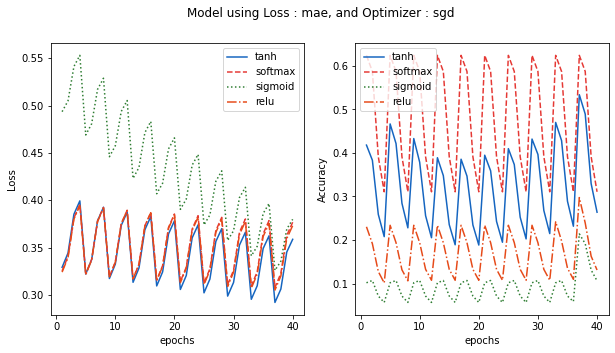

Optimizer :  adam
(4, 40)


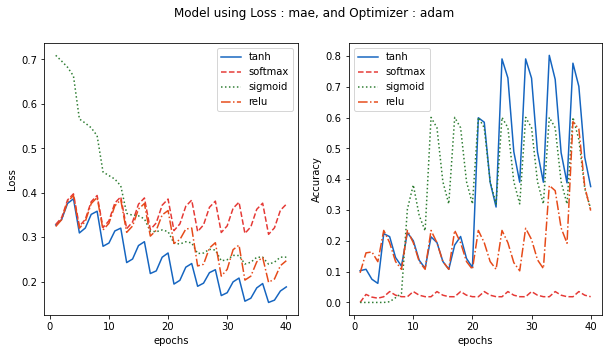

Optimizer :  adadelta
(4, 40)


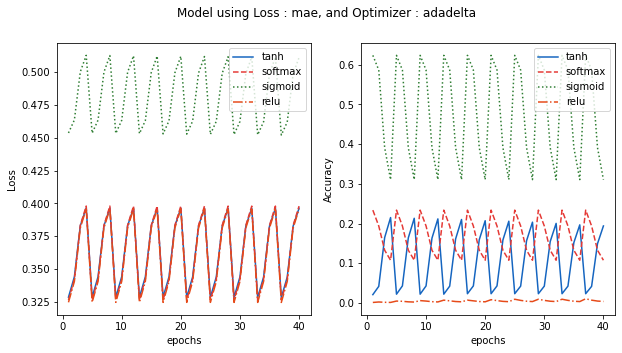

Optimizer :  adagrad
(4, 40)


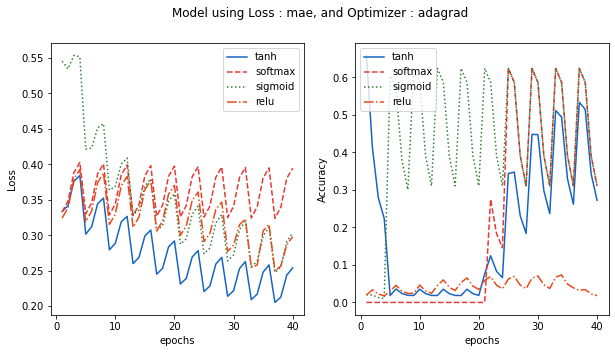

Optimizer :  adamax
(4, 40)


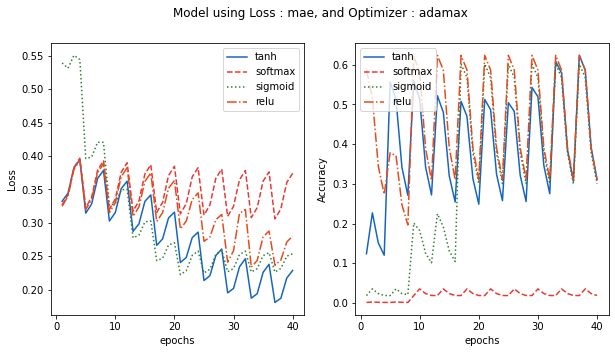

Optimizer :  nadam
(4, 40)


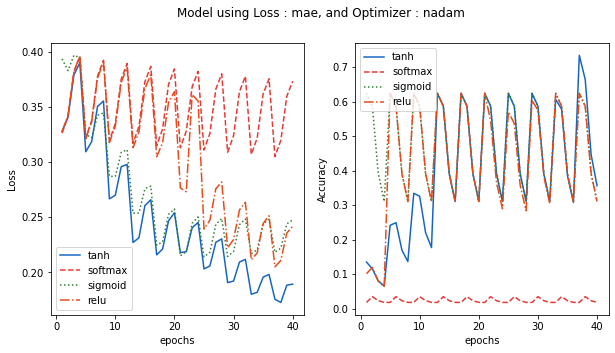

Optimizer :  ftrl
(4, 40)


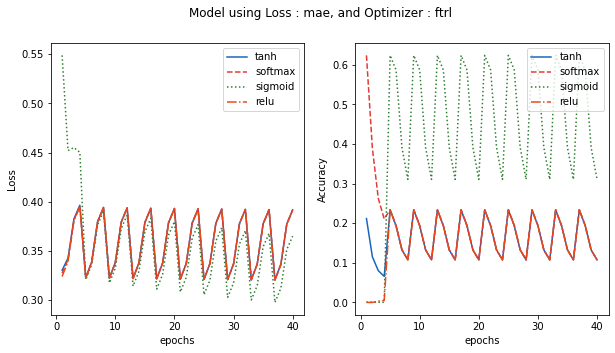

Loss :  mse
Optimizer :  sgd
(4, 40)


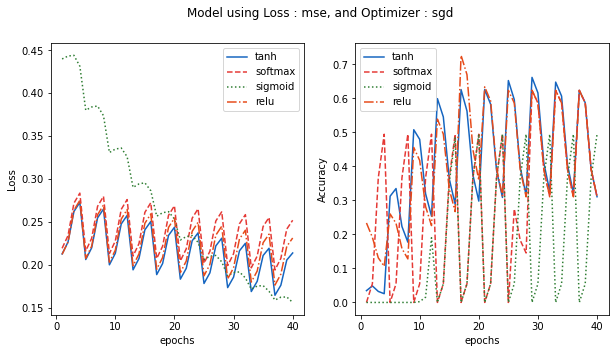

Optimizer :  adam
(4, 40)


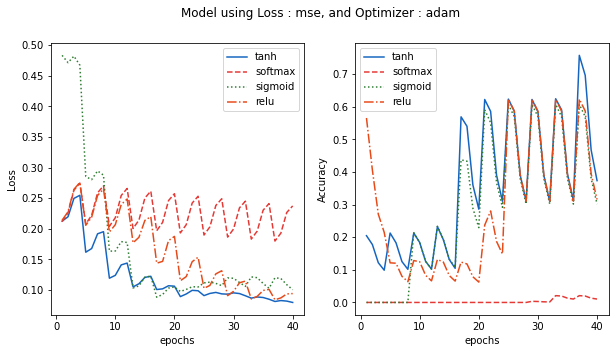

Optimizer :  adadelta
(4, 40)


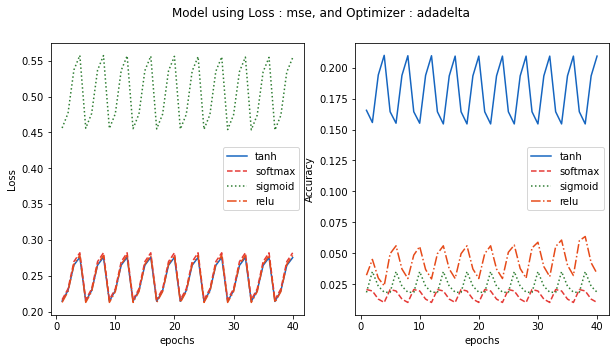

Optimizer :  adagrad
(4, 40)


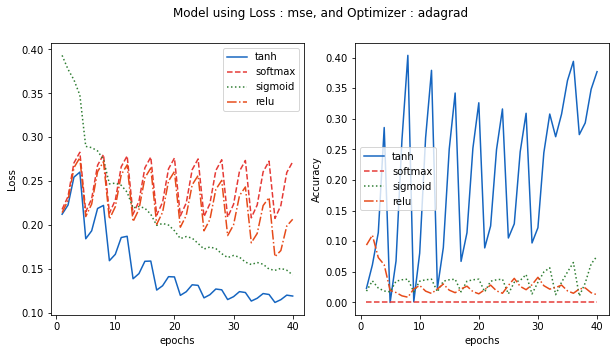

Optimizer :  adamax
(4, 40)


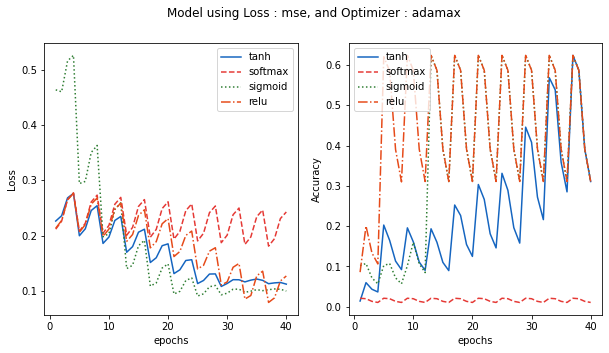

Optimizer :  nadam
(4, 40)


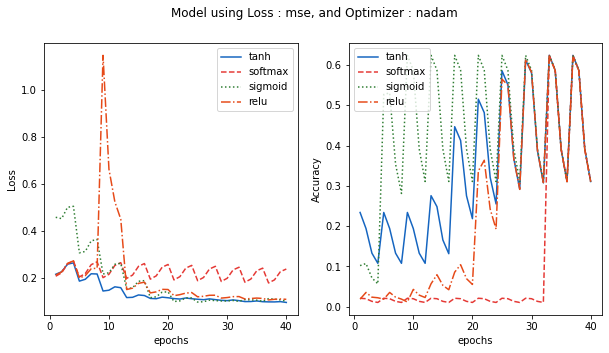

Optimizer :  ftrl
(4, 40)


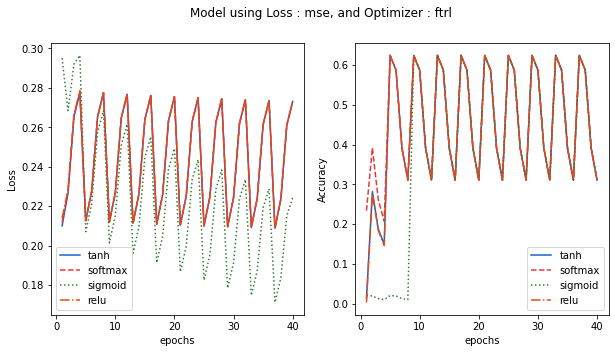

Loss :  msle
Optimizer :  sgd
(4, 40)


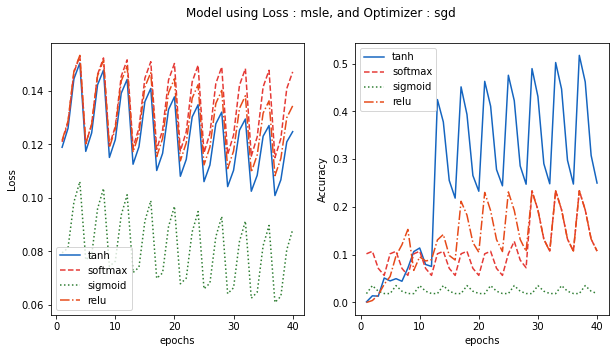

Optimizer :  adam
(4, 40)


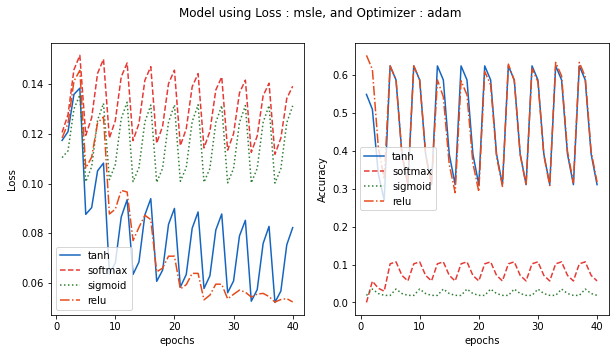

Optimizer :  adadelta
(4, 40)


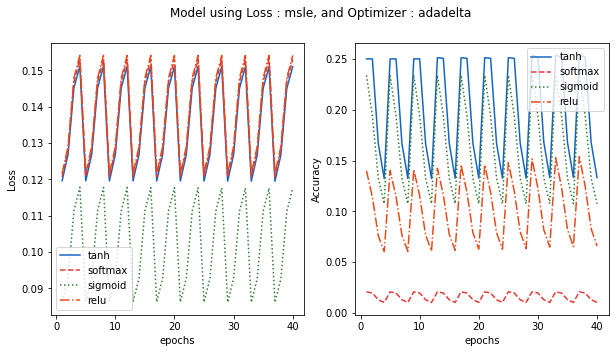

Optimizer :  adagrad
(4, 40)


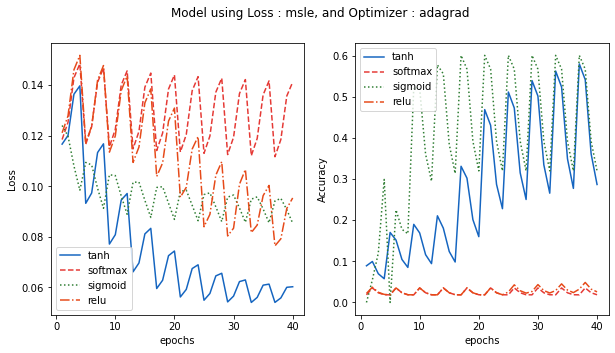

Optimizer :  adamax
(4, 40)


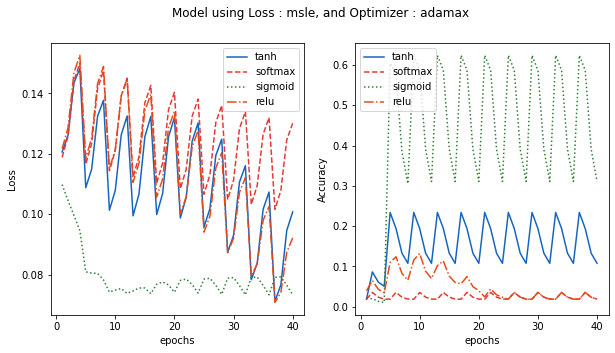

Optimizer :  nadam
(4, 40)


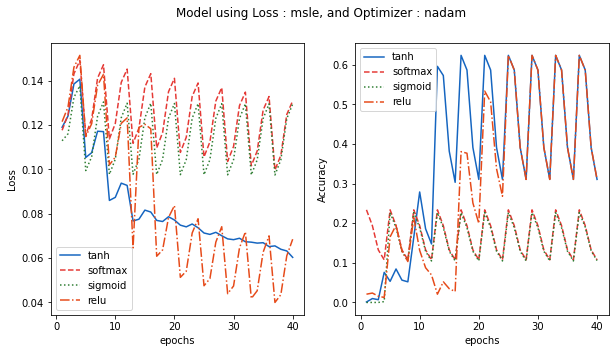

Optimizer :  ftrl
(4, 40)


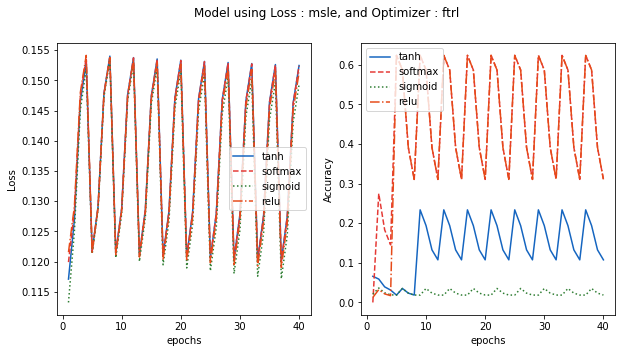

Loss :  Huber
Optimizer :  sgd
(4, 40)


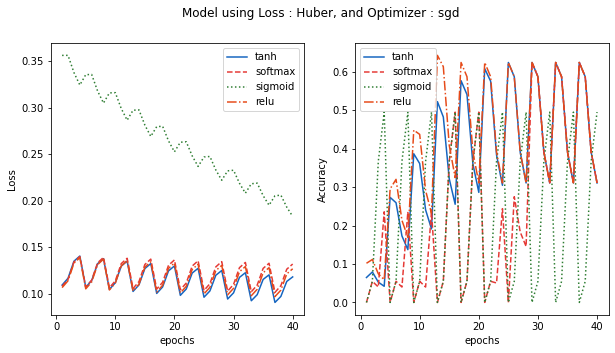

Optimizer :  adam
(4, 40)


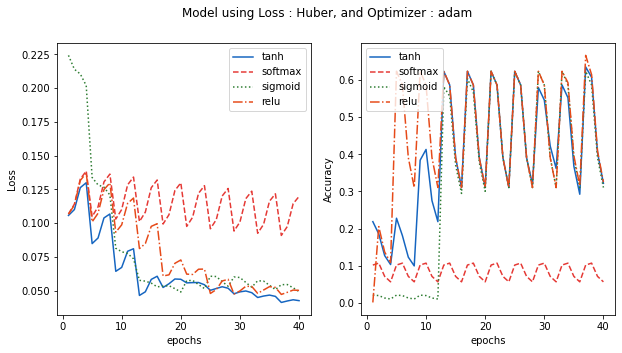

Optimizer :  adadelta
(4, 40)


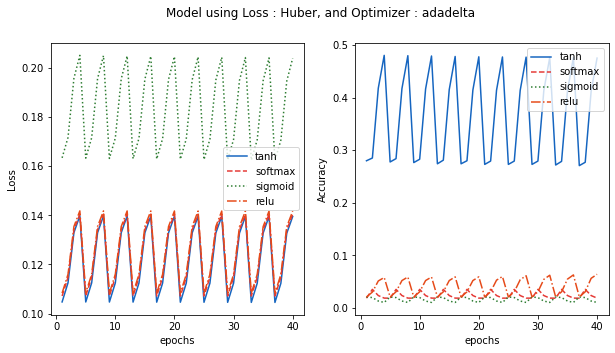

Optimizer :  adagrad
(4, 40)


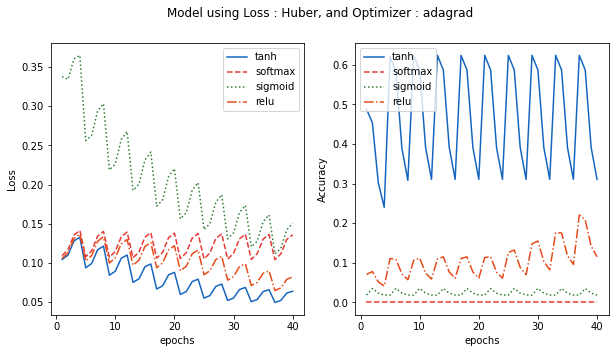

Optimizer :  adamax
(4, 40)


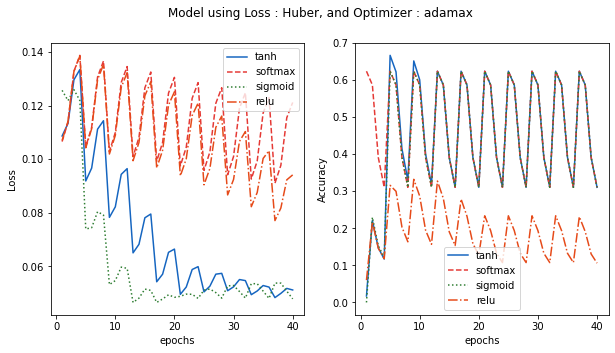

Optimizer :  nadam
(4, 40)


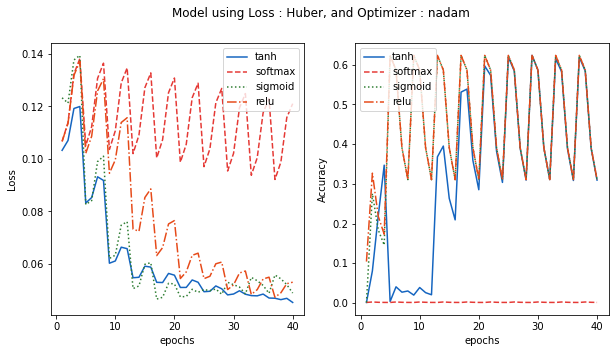

Optimizer :  ftrl
(4, 40)


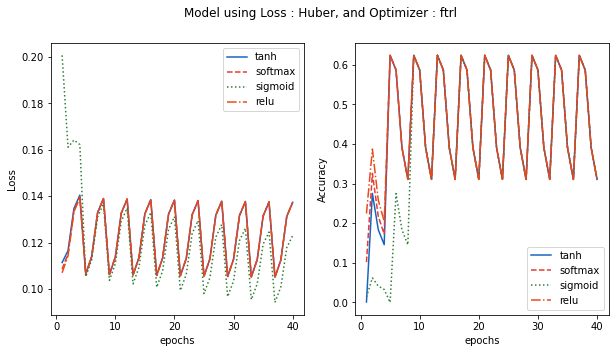

In [45]:
# Some additional parameters:
timesteps = 24 #96
dim = 8
batch_size = 36
epochs = 10

evalNorm2 = lossExplorer(losses, optimizers, actFuns,
                         df_data=df_plant1a,
                         dataTrimming=create_trimmed_data_norm,
                         testModel=anomalyModel2)

In [46]:
[df_evalNorm2_Loss, df_evalNorm2_Acc] = eval2df(evalNorm2, actFuns)

['Loss-Opt.' 'tanh' 'softmax' 'sigmoid' 'relu']


In [47]:
df_evalNorm2_Loss.head()

Loss-Opt.                 tanh              softmax  \
0       mae - sgd  0.35874155163764954  0.37679558992385864   
1      mae - adam  0.18827345967292786  0.37437039613723755   
2  mae - adadelta  0.39634832739830017  0.39797183871269226   
3   mae - adagrad   0.2540818452835083   0.3945741355419159   
4    mae - adamax   0.2287638783454895   0.3741037845611572   

               sigmoid                 relu  
0   0.3798508644104004    0.373229444026947  
1  0.25526005029678345   0.2471911907196045  
2   0.5112519264221191  0.39573967456817627  
3  0.30352330207824707    0.298206627368927  
4   0.2539132237434387  0.28026920557022095

In [48]:
df_evalNorm2_Acc.head()

Loss-Opt.                 tanh              softmax  \
0       mae - sgd  0.26378676295280457  0.31066176295280457   
1      mae - adam   0.3762255012989044  0.01868872530758381   
2  mae - adadelta  0.19393382966518402  0.10753676295280457   
3   mae - adagrad  0.27236518263816833  0.31066176295280457   
4    mae - adamax  0.31066176295280457  0.01868872530758381   

               sigmoid                   relu  
0  0.10631127655506134    0.13112744688987732  
1  0.30453431606292725     0.2981005012989044  
2  0.31066176295280457  0.0036764706019312143  
3  0.31066176295280457   0.018075980246067047  
4  0.30055147409439087    0.31066176295280457

In [49]:
df_evalNorm2_Loss.to_csv('path'+'EvalNorm2_Loss.csv')
df_evalNorm2_Acc.to_csv('path'+'EvalNorm2_Acc.csv')

##### 3.1.4 And finally let's try with another architecture, adding more layers and neurons

In [25]:
def anomalyModel3(X, timesteps, dim, actFun, nn=50):
    """
    Function to define a 'toy' neural network, to find
    the most accurate accurate activation functions and
    the loss and accuracy funtions as well
    X              : DF with the training data
    timesteps, dim : (int)
    actFun         : (str)
    nn             : (int) number of neurons
    """
    shape = (timesteps, dim)
    model = Sequential()
    # 5 Layers
    model.add(LSTM(nn, activation=actFun, input_shape=shape, return_sequences=True))
    model.add(LSTM(nn, activation=actFun, input_shape=shape, return_sequences=True))
    model.add(LSTM(nn, activation=actFun, input_shape=shape, return_sequences=True))
    model.add(LSTM(nn, activation=actFun, input_shape=shape, return_sequences=True))
    model.add(LSTM(nn, activation=actFun, input_shape=shape, return_sequences=True))
    model.add(Dense(dim))
    return model

Loss :  mae
Optimizer :  adam
(4, 40)


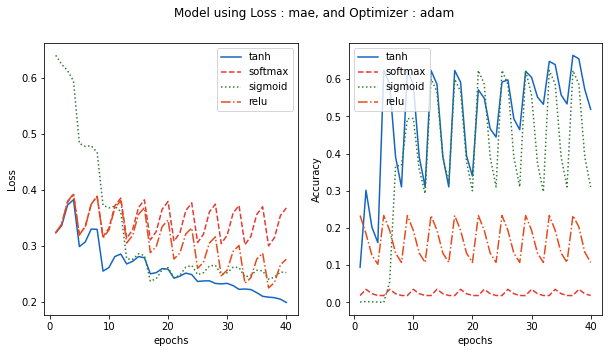

Optimizer :  adadelta
(4, 40)


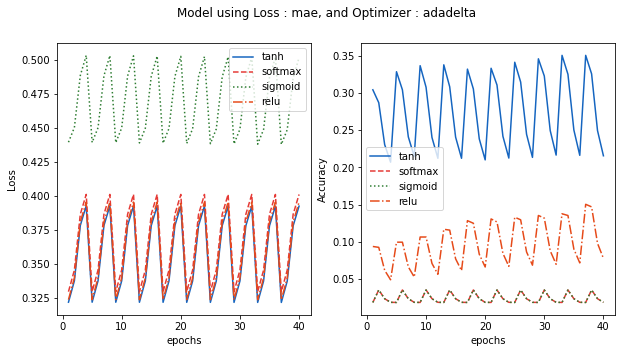

Optimizer :  adagrad
(4, 40)


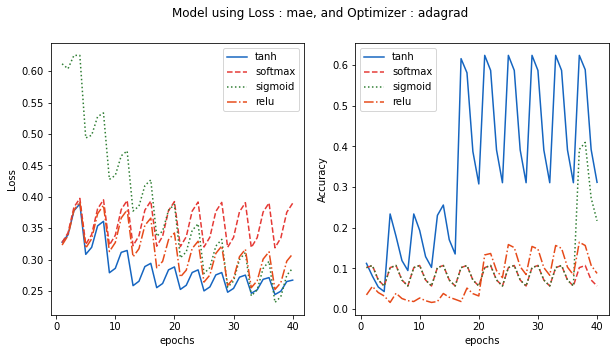

Optimizer :  adamax
(4, 40)


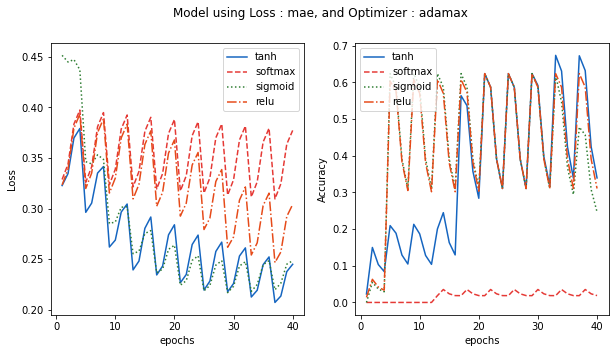

Loss :  mse
Optimizer :  adam
(4, 40)


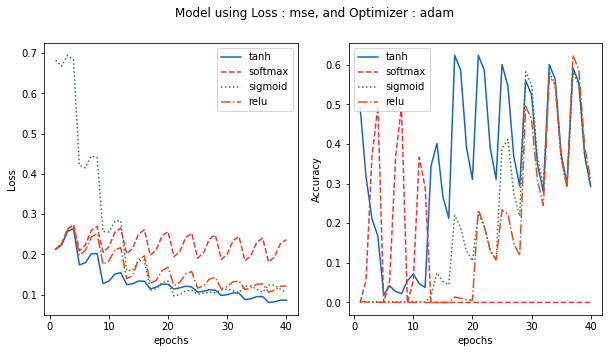

Optimizer :  adadelta
(4, 40)


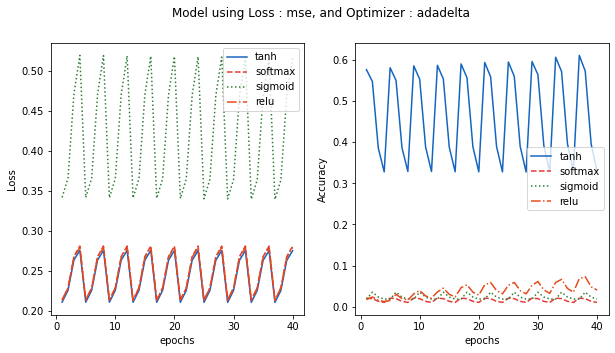

Optimizer :  adagrad
(4, 40)


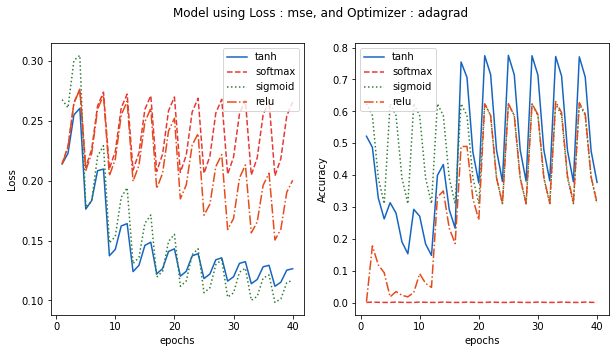

Optimizer :  adamax
(4, 40)


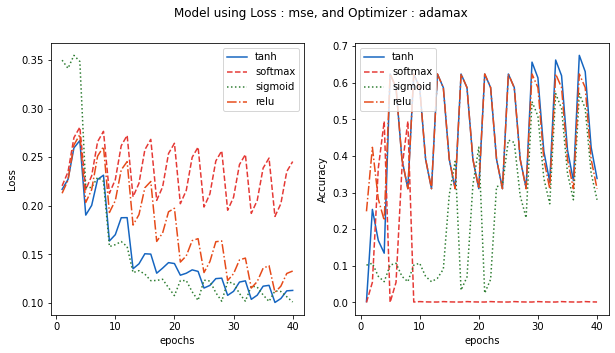

Loss :  msle
Optimizer :  adam
(4, 40)


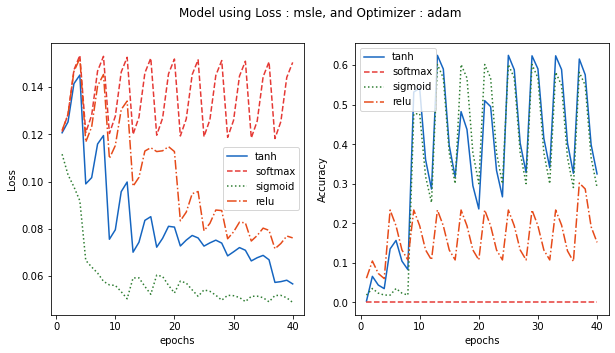

Optimizer :  adadelta
(4, 40)


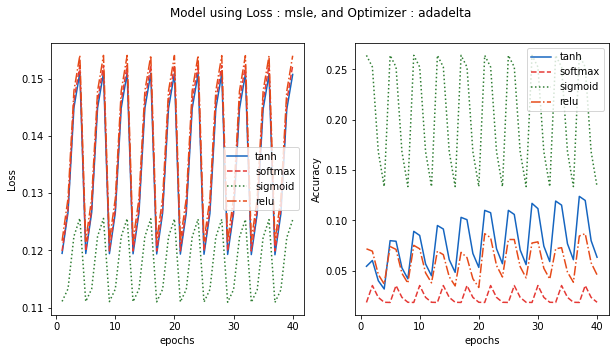

Optimizer :  adagrad
(4, 40)


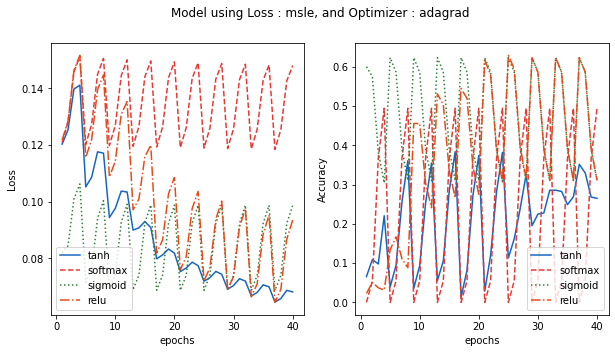

Optimizer :  adamax
(4, 40)


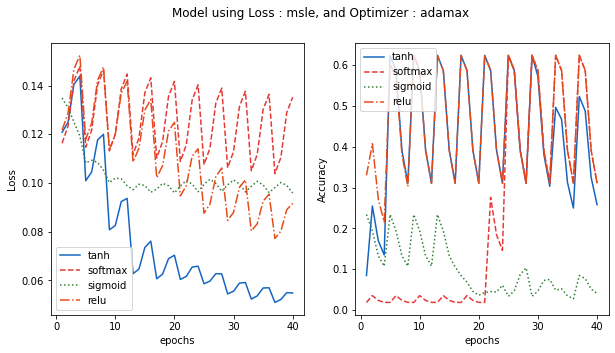

Loss :  Huber
Optimizer :  adam
(4, 40)


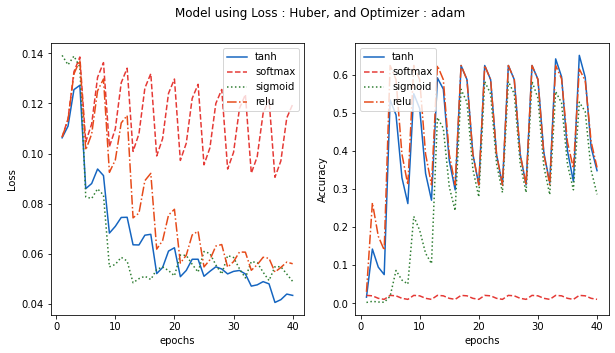

Optimizer :  adadelta
(4, 40)


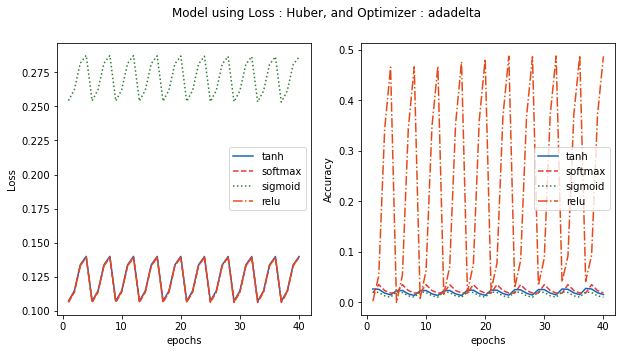

Optimizer :  adagrad
(4, 40)


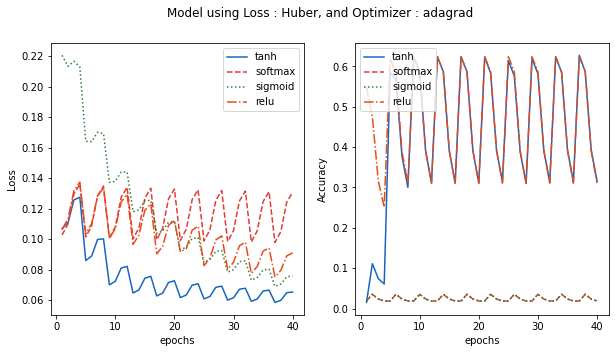

Optimizer :  adamax
(4, 40)


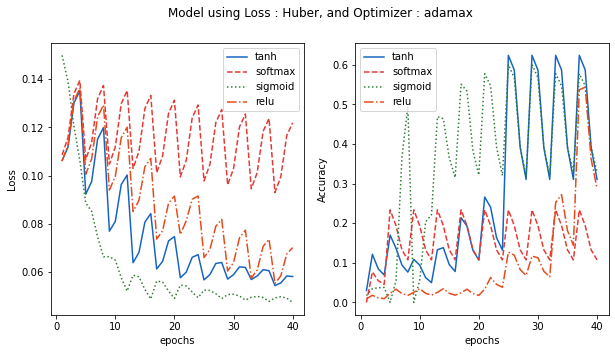

In [26]:
# Some additional parameters:
timesteps = 24 #96
dim = 8
batch_size = 36
epochs = 10

# Let's change a bit the considered functions:
actFuns = ['tanh', 'softmax', 'sigmoid', 'relu']
optimizers = ['adam', 'adadelta', 'adagrad', 'adamax']
losses = ['mae', 'mse', 'msle', 'Huber']

evalNorm3 = lossExplorer(losses, optimizers, actFuns,
                         df_data=df_plant1a,
                         dataTrimming=create_trimmed_data_norm,
                         testModel=anomalyModel3)

In [27]:
[df_evalNorm3_Loss, df_evalNorm3_Acc] = eval2df(evalNorm3, actFuns)

['Loss-Opt.' 'tanh' 'softmax' 'sigmoid' 'relu']


In [28]:
df_evalNorm3_Loss.head()

Loss-Opt.                 tanh              softmax  \
0      mae - adam    0.199175164103508   0.3680836260318756   
1  mae - adadelta   0.3925510346889496   0.4011247456073761   
2   mae - adagrad  0.26740971207618713  0.38979101181030273   
3    mae - adamax  0.24491646885871887  0.37721526622772217   
4      mse - adam  0.08652439713478088  0.23683717846870422   

               sigmoid                 relu  
0   0.2526281476020813   0.2765754461288452  
1   0.5015802979469299    0.395456999540329  
2  0.28650254011154175   0.3092048764228821  
3  0.24841947853565216  0.30409032106399536  
4  0.10530179738998413  0.12194555997848511

In [29]:
df_evalNorm3_Acc.head()

Loss-Opt.                 tanh              softmax  \
0      mae - adam   0.5196078419685364  0.01868872530758381   
1  mae - adadelta  0.21568627655506134  0.01868872530758381   
2   mae - adagrad   0.3115808963775635  0.05667892098426819   
3    mae - adamax   0.3394607901573181  0.01868872530758381   
4      mse - adam  0.29381126165390015                  0.0   

               sigmoid                 relu  
0  0.31066176295280457  0.10753676295280457  
1  0.01868872530758381   0.0778186246752739  
2  0.21691176295280457  0.08762254565954208  
3  0.24662990868091583  0.31066176295280457  
4   0.2907475531101227  0.31066176295280457

In [30]:
df_evalNorm3_Loss.to_csv('path'+'EvalNorm3_Loss.csv')
df_evalNorm3_Acc.to_csv('path'+'EvalNorm3_Acc.csv')

Let's look now for the best loss and optmizer functions

First let's define some functions to extract the smallest loss and the largest accuracy for each activation function:

In [31]:
def minLoss(df_loss, actFuns, n):
    """
    Function to obtain the lowest n values of the Loss function for each
    activation function contained in the array actFuns.
    Possible NaNs are replaced with a relative large number, to avoid
    problems that may appear during the test of this function.
    df_loss : DF with all loss values
    actFuns : Array with the name of the activation functions in df_All
    n       : Num. of values to extract
    """
    # Column with the name of the tested functions
    col0 = 'Loss-Opt.'
    # Replace NaNs
    df_loss.replace(np.nan, 1000.0, inplace=True)
    # Extract the n smallest loss values for each function in actFuns
    for i, fun in enumerate(actFuns):
        col1 = fun
        colA = 'Funs_' + str(i)
        temp = df_loss[[col0, col1]].sort_values(ascending=True, by=col1)
        #The index must be restarted, to avoid confusions when merging DFs
        temp = temp.head(n).reset_index(drop=True)
        if i == 0:
            df = temp
        else:
            df[[colA, col1]] = temp[[col0, col1]]
    return df

def maxAcc(df_acc, actFuns, n):
    """
    Function to obtain the largest n values of the calculated accuracy for
    each activation function contained in the array actFuns.
    Possible NaNs are replaced with a relative small number, to avoid
    problems that may appear during the test of this function.
    df_acc  : DF with all loss values
    actFuns : Array with the name of the activation functions in df_All
    n       : Num. of values to extract
    """
    # Column with the name of the tested functions
    col0 = 'Loss-Opt.'
    # Replace NaNs
    df_acc.replace(np.nan, 0.0, inplace=True)
    # Extract the n smallest loss values for each function in actFuns
    for i, fun in enumerate(actFuns):
        col1 = fun
        colA = 'Funs_' + str(i)
        temp = df_acc[[col0, col1]].sort_values(ascending=False, by=col1)
        #The index must be restarted, to avoid confusions when merging DFs
        temp = temp.head(n).reset_index(drop=True)
        if i == 0:
            df = temp
        else:
            df[[colA, col1]] = temp[[col0, col1]]
    return df

Loss functions:

In [127]:
minLoss(df_evalNoNorm_Loss, actFuns, 5).head()

Loss-Opt.                tanh           Funs_1             softmax  \
0     msle - adam      11.04638671875       msle - sgd  14.878033638000488   
1    msle - nadam  11.633811950683594    msle - adamax    15.9490385055542   
2  msle - adagrad  11.993793487548828     msle - nadam  16.031131744384766   
3   msle - adamax  12.206794738769531      msle - adam  16.055767059326172   
4      msle - sgd   13.11816692352295  msle - adadelta  16.118749618530273   

           Funs_2             sigmoid            Funs_3                relu  
0     msle - adam  12.776140213012695    msle - adagrad  11.723832130432129  
1    msle - nadam   12.83625602722168     msle - adamax   11.81883716583252  
2      msle - sgd  13.116872787475586   msle - adadelta  14.087181091308594  
3   msle - adamax  13.893230438232422  Huber - adadelta    1958.99365234375  
4  msle - adagrad  14.187478065490723       msle - ftrl   4.191620826721191

In [128]:
minLoss(df_evalNorm_Loss, actFuns, 5).head()

Loss-Opt.                  tanh           Funs_1              softmax  \
0    msle - nadam  0.028790263459086418     Huber - adam  0.11678921431303024   
1   Huber - nadam     0.032216876745224    Huber - nadam  0.12627196311950684   
2    Huber - adam   0.03360377252101898   Huber - adamax  0.12705586850643158   
3     msle - adam   0.03558141738176346     msle - nadam  0.12837234139442444   
4  Huber - adamax   0.04338059201836586  Huber - adagrad    0.129381000995636   

            Funs_2              sigmoid          Funs_3                  relu  
0     Huber - adam  0.04753841087222099   Huber - nadam   0.04930703341960907  
1    Huber - nadam  0.04896567761898041    Huber - adam  0.060518063604831696  
2   Huber - adamax  0.05156875401735306    msle - nadam   0.06558922678232193  
3      msle - adam  0.06988097727298737  Huber - adamax   0.07027332484722137  
4  Huber - adagrad  0.07338672876358032   msle - adamax   0.07546781748533249

In [129]:
minLoss(df_evalNorm2_Loss, actFuns, 5).head()

Loss-Opt.                  tanh          Funs_1              softmax  \
0    Huber - adam   0.04251272976398468    Huber - adam  0.11973591148853302   
1   Huber - nadam    0.0452328659594059   Huber - nadam  0.12105561792850494   
2  Huber - adamax  0.051213499158620834  Huber - adamax  0.12118211388587952   
3  msle - adagrad  0.060282349586486816   msle - adamax  0.13013887405395508   
4    msle - nadam   0.06031985580921173    msle - nadam  0.13098950684070587   

           Funs_2              sigmoid           Funs_3                  relu  
0  Huber - adamax   0.0479045994579792     Huber - adam  0.050121694803237915  
1   Huber - nadam  0.04882018268108368      msle - adam  0.052291981875896454  
2    Huber - adam   0.0492364726960659    Huber - nadam   0.05294996500015259  
3   msle - adamax  0.07328229397535324     msle - nadam   0.06852469593286514  
4  msle - adagrad  0.08542227745056152  Huber - adagrad   0.08225829899311066

In [32]:
minLoss(df_evalNorm3_Loss, actFuns, 5).head()

Loss-Opt.                  tanh            Funs_1  \
0     Huber - adam   0.04338154196739197      Huber - adam   
1    msle - adamax   0.05482017248868942    Huber - adamax   
2      msle - adam   0.05671105906367302   Huber - adagrad   
3   Huber - adamax  0.058109331876039505     msle - adamax   
4  Huber - adagrad   0.06541389226913452  Huber - adadelta   

               softmax           Funs_2               sigmoid  \
0  0.11964885890483856   Huber - adamax   0.04733589291572571   
1  0.12194643169641495      msle - adam  0.048870839178562164   
2   0.1308634877204895     Huber - adam   0.04895186424255371   
3  0.13519231975078583  Huber - adagrad   0.07588936388492584   
4  0.13926228880882263    msle - adamax   0.09589175879955292   

            Funs_3                  relu  
0     Huber - adam  0.056009527295827866  
1   Huber - adamax   0.07012395560741425  
2      msle - adam    0.0761798694729805  
3  Huber - adagrad   0.09103115648031235  
4    msle - adamax   0.09164128452539444

And now let's check the accuracy:

In [133]:
maxAcc(df_evalNoNorm_Acc, actFuns, 5).head()

Loss-Opt.                tanh            Funs_1              softmax  \
0    mse - nadam  0.7751225233078003      Huber - adam  0.37683823704719543   
1     msle - sgd   0.734987735748291       mse - nadam  0.37683823704719543   
2  mse - adagrad  0.6727941036224365  Huber - adadelta  0.37683823704719543   
3   mse - adamax  0.6636029481887817    mse - adadelta  0.37683823704719543   
4     mse - ftrl   0.656862735748291     msle - adamax   0.3498774468898773   

           Funs_2              sigmoid        Funs_3                 relu  
0  msle - adagrad  0.37683823704719543   msle - ftrl  0.45618873834609985  
1      mse - ftrl  0.37683823704719543   mse - nadam   0.4515931308269501  
2       mae - sgd  0.35600489377975464  Huber - adam   0.4479166567325592  
3      mse - adam   0.3498774468898773   msle - adam  0.42555147409439087  
4     Huber - sgd   0.3498774468898773    mae - ftrl  0.38235294818878174

In [134]:
maxAcc(df_evalNorm_Acc, actFuns, 5).head()

Loss-Opt.                tanh           Funs_1              softmax  \
0     mse - adam   0.688112735748291        mae - sgd  0.31066176295280457   
1   mse - adamax            0.640625        mse - sgd  0.31066176295280457   
2   msle - nadam  0.6378676295280457    msle - adamax  0.31066176295280457   
3    mse - nadam  0.6164215803146362  msle - adadelta  0.31066176295280457   
4  Huber - nadam  0.6026347875595093       mse - ftrl  0.31066176295280457   

           Funs_2             sigmoid         Funs_3                 relu  
0     Huber - sgd  0.4947916567325592     mse - adam  0.49295341968536377  
1   mae - adagrad  0.4947916567325592      mse - sgd   0.4797794222831726  
2  mse - adadelta  0.4947916567325592    mae - nadam   0.3863357901573181  
3   mse - adagrad  0.4947916567325592  mse - adagrad   0.3848039209842682  
4    Huber - adam   0.328737735748291  Huber - nadam  0.38174018263816833

In [135]:
maxAcc(df_evalNorm2_Acc, actFuns, 5).head()

Loss-Opt.                 tanh          Funs_1              softmax  \
0  Huber - adadelta  0.47549018263816833       mae - sgd  0.31066176295280457   
1     mse - adagrad  0.37714460492134094       mse - sgd  0.31066176295280457   
2        mae - adam   0.3762255012989044  Huber - adamax  0.31066176295280457   
3        mse - adam   0.3737744987010956     Huber - sgd  0.31066176295280457   
4       mae - nadam  0.35631126165390015     msle - ftrl  0.31066176295280457   

           Funs_2              sigmoid         Funs_3                 relu  
0     Huber - sgd   0.4947916567325592   Huber - adam  0.32536765933036804  
1       mse - sgd   0.4947916567325592    msle - adam   0.3174019753932953  
2  msle - adagrad  0.31985294818878174     mse - adam  0.31587010622024536  
3    Huber - ftrl  0.31066176295280457   Huber - ftrl  0.31066176295280457  
4    Huber - adam  0.31066176295280457  Huber - nadam  0.31066176295280457

In [33]:
maxAcc(df_evalNorm3_Acc, actFuns, 5).head()

Loss-Opt.                 tanh          Funs_1              softmax  \
0     mae - adam   0.5196078419685364  msle - adagrad   0.4947916567325592   
1  mse - adagrad  0.37745097279548645   msle - adamax  0.31066176295280457   
2   Huber - adam   0.3480392098426819  Huber - adamax  0.10753676295280457   
3   mae - adamax   0.3394607901573181   mae - adagrad  0.05667892098426819   
4   mse - adamax   0.3385416567325592      mae - adam  0.01868872530758381   

           Funs_2              sigmoid            Funs_3                 relu  
0  Huber - adamax    0.328737735748291  Huber - adadelta  0.48713234066963196  
1      mae - adam  0.31066176295280457      Huber - adam  0.35631126165390015  
2   mse - adagrad  0.31066176295280457     mse - adagrad   0.3134191036224365  
3  msle - adagrad  0.31066176295280457      mae - adamax  0.31066176295280457  
4      mse - adam   0.2907475531101227        mse - adam  0.31066176295280457

#### 3.2 Machine Learning Model

We now proceed to define a model, which uses a machine learning algorithm, in order to predict the DC power generated by a solar panel. We can start with the correlation plots and diferent plots between the different variables storaged in the DFs.

We start defining some functions to make the plots

In [150]:
# Some colors, usign Google Material Design Color Palette
gblue = '#1565C0'   #blue 800
gred = '#E53935'    #red 600
ggreen = '#2E7D32'  #green 800
gorange = '#E64A19' #deep orange 700

We move now to plot the variables and check a possible correlation. The functions `plotVars` and `plotCorr` are defined in the corresponding helper file.

We start looking at the correlation

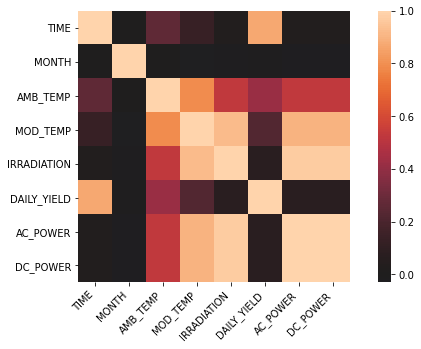

In [153]:
cols = ['TIME', 'MONTH', 'AMB_TEMP', 'MOD_TEMP',
        'IRRADIATION', 'DAILY_YIELD', 'AC_POWER',
        'DC_POWER']
plotCorr(df_plant1a, cols) 

And now we check the relation between variables, particularly between the DC_POWER and the environmental variables

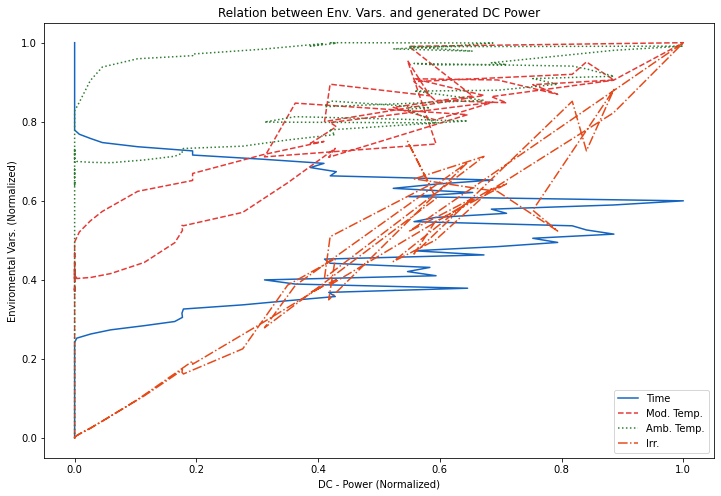

In [154]:
var_x = 'DC_POWER'
var_y = ['TIME', 'MOD_TEMP', 'AMB_TEMP', 'IRRADIATION']
labels = ['Time', 'Mod. Temp.', 'Amb. Temp.', 'Irr.']
x_lab = 'DC - Power (Normalized)'
y_lab = 'Enviromental Vars. (Normalized)'
title = 'Relation between Env. Vars. and generated DC Power'
plotVars(df=df_plant1a, var1=var_x, var2=var_y,
         lab_all=labels, x_lab=x_lab, y_lab=y_lab,
         title=title, nslices=96, xnorm=1, ynorm=1)

It is clear that there is a dependence between the environmental variables and the generated DC power. Such relation is not necessarily linear, but we will start with a linear regression

In [155]:
lm = LinearRegression(normalize=True)

In [156]:
cols = ['TIME', 'MONTH', 'MOD_TEMP', 'AMB_TEMP', 'IRRADIATION']
X = df_plant1a[cols]
y = df_plant1a['DC_POWER']

In [157]:
lm.fit(X, y)
yhat = lm.predict(X)
print('The R-square is: ', lm.score(X, y))
print('The MSE is : ', np.sqrt(mean_squared_error(y, yhat)))

The R-square is:  0.9412642803209434
The MSE is :  889.6912350003533


We try now with different polynomials, of degree between 2 and 7:

In [158]:
def evalPoly(x, y, n_min, n_max):
    """
    Function to evaluate linear regression with polynomial features
    x     : data to fit
    y     : target
    n_min : Min. degree
    n_max : Max. degree
    """
    for n in range(n_min, n_max+1):
        sl = StandardScaler()
        pr = PolynomialFeatures(degree=n, include_bias=False)
        lr = LinearRegression()
        pipe = Pipeline([('scale', sl),
                         ("polynomial_features", pr),
                         ("linear_regression", lr)])
        pipe.fit(x, y)
        scores = cross_val_score(pipe, x, y, cv=5)
        print('Degree n = {}'.format(n))
        print("Accuracy = {:.2e}(+/- {:.2e})".format(scores.mean(), scores.std()*2))
        print('R-square = {}\n'.format(pipe.score(x, y)))

In [159]:
cols = ['TIME', 'MONTH', 'MOD_TEMP', 'AMB_TEMP', 'IRRADIATION']
X = df_plant1a[cols]
y = df_plant1a['DC_POWER']

In [160]:
evalPoly(X, y, 1, 7)

Degree n = 1
Accuracy = 9.36e-01(+/- 1.13e-01)
R-square = 0.9412642803209434

Degree n = 2
Accuracy = 9.38e-01(+/- 1.03e-01)
R-square = 0.9477783275621594

Degree n = 3
Accuracy = 9.33e-01(+/- 1.16e-01)
R-square = 0.9529836915364337

Degree n = 4
Accuracy = 7.47e-01(+/- 7.36e-01)
R-square = 0.9580444761090117

Degree n = 5
Accuracy = -4.51e+00(+/- 2.01e+01)
R-square = 0.9651221405271264

Degree n = 6
Accuracy = -3.42e+04(+/- 1.32e+05)
R-square = 0.9721069272513474

Degree n = 7
Accuracy = -1.40e+06(+/- 3.45e+06)
R-square = 0.9810873168696701



In [161]:
def evalSVR(x, y, kernel, n_min, n_max):
    """
    Function to evaluate Epsilon-Support Vector Regression (SVR)
    x      : data to fit
    y      : target
    kernel : (str) kernel type (linear, poly, rbf...)
    n_min  : Min. degree
    n_max  : Max. degree
    """
    if kernel != 'poly':
        n_min = 1
        n_max = 1
#    scx = StandardScaler()
#    scy = StandardScaler()
#    x = scx.fit_transform(x)
#    y = scy.fit_transform(y)
    for n in range(n_min, n_max+1):
        scr = StandardScaler()
        svr = SVR(kernel=kernel, degree=n)
        pipe = Pipeline([('standardscaler', scr),
                         ('svr', svr)])
        pipe.fit(x,y)
        scores = cross_val_score(pipe, x, y, cv=5)
        print('Kernel : {}'.format(kernel))
        if kernel == "poly":
            print('Degree n = {}'.format(n))
        print("Accuracy = {:.2e}(+/- {:.2e})".format(scores.mean(), scores.std()*2))
        print('R-square = {}\n'.format(pipe.score(x, y)))

In [162]:
cols = ['TIME', 'MONTH', 'MOD_TEMP', 'AMB_TEMP', 'IRRADIATION']
x = df_plant1a[cols]
y = df_plant1a['DC_POWER']

In [163]:
evalSVR(x, y, 'linear', 1, 1)

Kernel : linear
Accuracy = 8.45e-01(+/- 8.83e-02)
R-square = 0.8961525752263957



In [164]:
evalSVR(x, y, 'rbf', 1, 1)

Kernel : rbf
Accuracy = -3.19e-01(+/- 6.95e-02)
R-square = -0.2520621428620804



In [165]:
evalSVR(x, y, 'poly', 1, 7)

Kernel : poly
Degree n = 1
Accuracy = 7.65e-02(+/- 5.09e-02)
R-square = 0.17350585025919707

Kernel : poly
Degree n = 2
Accuracy = -3.62e-01(+/- 9.83e-02)
R-square = -0.31223856748829504

Kernel : poly
Degree n = 3
Accuracy = 4.90e-02(+/- 3.27e-01)
R-square = 0.1150112652936569

Kernel : poly
Degree n = 4
Accuracy = 4.39e-02(+/- 5.01e-01)
R-square = 0.09868776880419516

Kernel : poly
Degree n = 5
Accuracy = 1.24e-01(+/- 4.61e-01)
R-square = 0.15989907225670863

Kernel : poly
Degree n = 6
Accuracy = 2.18e-02(+/- 3.99e-01)
R-square = 0.054181014483501884

Kernel : poly
Degree n = 7
Accuracy = 1.27e-02(+/- 3.78e-01)
R-square = 0.05415842769622026

